In [ ]:
%run PNe_fitting

In [ ]:
%whos
%who_ls


In [1]:
gal_name = "FCC167"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, data_cube_y_x, robust_sigma
from PNLF_new import open_data, reconstructed_image, completeness
import yaml
import sep
from photutils import CircularAperture
import scipy as sp
from scipy.stats import norm
from scipy import stats

%config InlineBackend.figure_format = 'retina'

In [3]:
# functions
# Open Fits file and assign to raw_data

hdulist = fits.open(gal_name+"_data/"+gal_name+"_residuals_list.fits")
hdr = hdulist[0].header
wavelength = np.exp(hdulist[1].data)

if gal_name == "FCC219":
    x_data, y_data, n_data = data_cube_y_x(len(hdulist[0].data))
else:
    y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
    
    
n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])


def progbar(curr, total, full_progbar):
    frac = curr/total
    filled_progbar = round(frac*full_progbar)
    print('\r', '#'*filled_progbar + '-'*(full_progbar-filled_progbar), '[{:>7.2%}]'.format(frac), str(curr)+"/"+ str(total), end='')

In [4]:
x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "[OIII] Flux", "M 5007 error","A/rN", "rad D", "redchi", "Filter"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["Filter"] = "Y"

# Objective Residual Cube
obj_residual_cube = fits.open("exported_data/"+gal_name+"/resids_obj.fits")

# Data Residual Cube
data_residual_cube = fits.open("exported_data/"+gal_name+"/resids_data.fits")


def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs([robust_sigma(dat) for dat in extract_data[p]])
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[gal_name]

emission_dict = galaxy_data["emissions"]

D = galaxy_data["Distance"]

z = galaxy_data["z"]

/auto/data/tspriggs/Github/MUSE_PNe_fitting/MUSE_Models.py:136: RuntimeWarning: invalid value encountered in true_divide
  u2 = (d/(9.0*mad))**2  # c = 9
/auto/data/tspriggs/Github/MUSE_PNe_fitting/MUSE_Models.py:137: RuntimeWarning: invalid value encountered in less
  good = u2 < 1.0
/auto/data/tspriggs/Github/MUSE_PNe_fitting/MUSE_Models.py:141: RuntimeWarning: invalid value encountered in double_scalars
  sigma = np.sqrt(num/(den*(den - 1.0)))  # see note in above reference


In [5]:
PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, LSF=2.81, em_dict=None, vary_LSF=False, vary_PSF=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.001, max=1e5, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-40., max=wave+40.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("y_0", value=((n_pixels//2.) +1), min=((n_pixels//2.) +1)-3, max=((n_pixels//2.) +1)+3)
    PNe_multi_params.add("LSF", value=LSF, vary=vary_LSF, min=LSF-1, max=LSF+1)
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_PSF)
    PNe_multi_params.add("beta", value=beta, min=beta - beta_err, max=beta + beta_err, vary=vary_PSF)   
    PNe_multi_params.add("Gauss_bkg",  value=0.0001, vary=True)#1, min=-200, max=500)
    PNe_multi_params.add("Gauss_grad", value=0.0001, vary=True)#1, min=-2, max=2)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
emission_amp_list = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

def run_minimiser(parameters):
    for PNe_num in np.arange(0, len(x_PNe)):
        progbar(int(PNe_num)+1, len(x_PNe), 40)
        useful_stuff = []        
        PNe_minimizer     = lmfit.Minimizer(PNe_residuals_3D,PNe_multi_params, fcn_args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        multi_fit_results = PNe_minimizer.minimize()
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num]  = useful_stuff[1][0]
        F_xy_list[PNe_num]  = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        emission_amp_list[PNe_num]  = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num]     = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([robust_sigma(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude
    
    # chi square analysis
    gauss_list, redchi, Chi_sqr = [], [], []
    for p in range(len(x_PNe)):
        PNe_n = np.copy(PNe_spectra[p])
        flux_1D = np.copy(F_xy_list[p][0])
        A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))
    
        def gaussian(x, amplitude, mean, stddev, bkg, grad):
            return ((bkg + grad*x) + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                    (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))
    
        list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]
        for kk in range(len(PNe_n)):
            temp = np.copy(list_of_gauss[kk])
            idx  = np.where(PNe_n[kk] == 0.0)[0]
            temp[idx] = 0.0
            PNe_n[kk,idx] = 1.0
            list_of_gauss[kk] = np.copy(temp)
        rN   = robust_sigma(PNe_n - list_of_gauss)
        res  = PNe_n - list_of_gauss
        Chi2 = np.sum((res**2)/(rN**2))
        s    = np.shape(PNe_n)
        redchi.append(Chi2/(len(wavelength)*n_pixels**2 - PNe_minimizer.nfree))
        gauss_list.append(list_of_gauss)
        Chi_sqr.append(Chi2)
    
    PNe_df['Chi2']   = Chi_sqr
    PNe_df["redchi"] = redchi
    
    # velocity
    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5006.77) / 5006.77) / 1000.    
        
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
        
    if "hb" in emission_dict:
        PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Hb ratio

    if "ha" in emission_dict:
        PNe_df["Ha Flux"] = total_Flux[:, 1]
    
    PNe_df["m 5007"] = -2.5 * np.log10(PNe_df["[OIII] Flux"].values) - 13.74


In [6]:
print("Running fitter")
gen_params(wave=5007.*(1+z)-3, FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict, vary_LSF=False, vary_PSF=False)
run_minimiser(PNe_multi_params)

Running fitter
 ######################################## [100.00%] 125/125

## The Great Filter

113


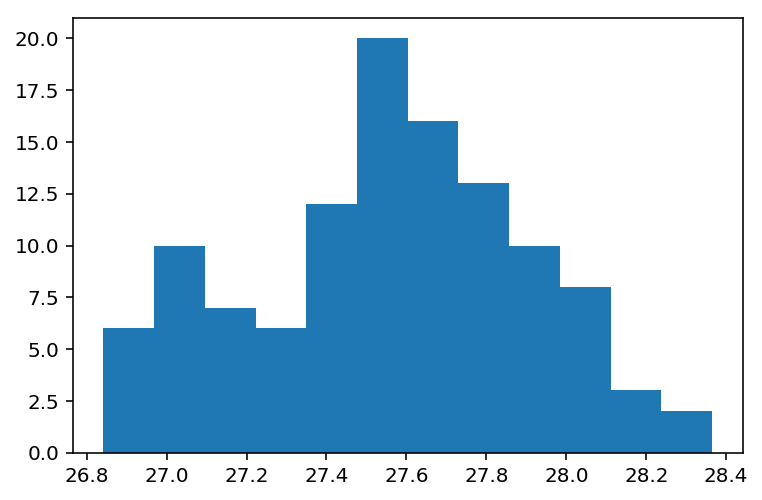

In [7]:
PNe_df["Filter"] = "Y"
PNe_df.loc[PNe_df["A/rN"]<3., "Filter"] = "N"
# reduced Chi sqr cut
redchi_med = np.median(PNe_df["redchi"].values)
redchi_std = robust_sigma(PNe_df["redchi"].values)
lower_redchi = redchi_med - 3*redchi_std
upper_redchi = redchi_med + 3*redchi_std
PNe_df.loc[(PNe_df["redchi"]>=upper_redchi) & (PNe_df["redchi"]<=lower_redchi), "Filter"] = "N"


## FCC167
if gal_name == "FCC167":
    PNe_df.loc[PNe_df["PNe number"]==30, "Filter"] = "N" # Over luminous [OIII] source
    PNe_df.loc[PNe_df["PNe number"]==15, "Filter"] = "N" # SNR maybe, extended source with dual peaked [OIII] 5007
    #PNe_df.loc[PNe_df["PNe number"]==126, "Filter"] = "N" # SNR maybe, extended source
## FCC219
#elif gal_name == "FCC219":
    # Put filtered out objects here
    

print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
plt.hist(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"], bins=12);
plt.show()

# Error analysis

In [8]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
def error_sim(n_sim, n_PNe):
    mean_flux = np.ones(n_PNe)
    flux_err  = np.ones(n_PNe)
    mean_m5007 = np.ones(n_PNe)
    m5007_err = np.ones(n_PNe)
    for n in np.arange(0,n_PNe):
        Moff_A_dist = np.random.normal(emission_amp_list[n][0], moff_A_err[n][0],n_sim)
        FWHM_dist = np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], n_sim)
        beta_dist = np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], n_sim)
        x_0_dist = np.random.normal(list_of_x[n], x_0_err[n][0], n_sim)
        y_0_dist = np.random.normal(list_of_y[n], y_0_err[n][0], n_sim)
        
        flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
        
        mean_flux[n], flux_err[n] = norm.fit(flux_array)
        
        mean_m5007[n], m5007_err[n] = norm.fit(-2.5*np.log10(flux_array)-13.72)

    return mean_flux, flux_err, mean_m5007, m5007_err

mean_flux, PNe_df["Flux error"], mean_m5007, PNe_df["m 5007 error"] = error_sim(5000, len(x_PNe))

## Show F_err in percentage terms
PNe_df["F[OIII] err percent"] = (PNe_df["Flux error"] / PNe_df["[OIII] Flux"])*100

## Distance estimate with error

In [9]:
p_n = int(PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(1, "m 5007").index.values)
flux = PNe_df["[OIII] Flux"].iloc[p_n]
flux_err = PNe_df["Flux error"].iloc[p_n]
m = PNe_df["m 5007"].iloc[p_n]
m_err = PNe_df["m 5007 error"].iloc[p_n]

Dist_est = 10.**(((m + 4.51) -25.) / 5.)
dist_diff_p = 10.**(((m+m_err + 4.51) -25.) / 5.)
print("Lower: ", dist_diff_p)
dist_diff_m = 10.**(((m-m_err + 4.51) -25.) / 5.)
print("Upper: ", dist_diff_m)
print("Distance Estimate from PNLF: ", "{:.3f}".format(Dist_est), "Mpc, +/-", "{:.3f}".format(np.median((Dist_est- dist_diff_p, dist_diff_m -Dist_est))),"Mpc")

dM =  5. * np.log10(Dist_est) + 25.
dM_lower = 5. * np.log10(dist_diff_p) + 25.
dM_upper = 5. * np.log10(dist_diff_m) + 25.

print("dM = {:.4f}".format(dM),"+/-", "{:.4f}".format(np.abs(dM_upper-dM)))

PNe_df["M 5007"] = PNe_df["m 5007"] - dM

Lower:  19.03387542666408
Upper:  18.24795694065295
Distance Estimate from PNLF:  18.637 Mpc, +/- -0.393 Mpc
dM = 31.3519 +/- 0.0458


-121.39944319837441 133.8428294647608


Text(0, 0.5, 'N PNe / bin')

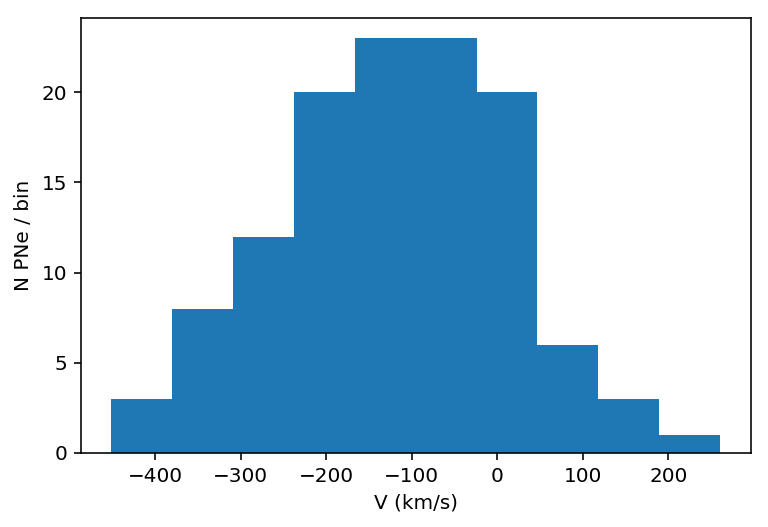

In [19]:
plt.hist(PNe_df["V (km/s)"],bins=10)
mu, std = norm.fit(PNe_df["V (km/s)"])
print(mu, std)
plt.xlabel("V (km/s)")
plt.ylabel("N PNe / bin")

## Pixel array size experiment

In [ ]:
# n_pix_dist = 31
n_range = np.arange(11,22,2)
store_here = np.ones(len(n_range))
for i, n_pix_dist in enumerate(n_range):
    coordinates = [(n,m) for n in range(n_pix_dist) for m in range(n_pix_dist)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_sim = 10000
    Moff_A_dist = np.random.normal(emission_amp_list[40][0], moff_A_err[40][0],n_sim)
    FWHM_dist = np.random.normal(4.06, 0.018, n_sim)
    beta_dist = np.random.normal(3.41, 0.167, n_sim)
    x_0_dist = np.random.normal(list_of_x[40], x_0_err[40][0], n_sim)
    y_0_dist = np.random.normal(list_of_y[40], y_0_err[40][0], n_sim)
    
    def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
    flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
    plt.hist(flux_array)
    plt.axvline(PNe_df["[OIII] Flux"].iloc[40])
    #plt.xlim(3.6e-17, 4.2e-17)
    #print(PNe_df["[OIII] Flux"].iloc[40])
    #print(PNe_df["m 5007"].iloc[40])
    mu_f, std_f = norm.fit(flux_array)
    #print(mu, (std/mu)*100,"%")
    plt.axvline(mu_f, c="r")
    
    mu, std = norm.fit(-2.5*np.log10(flux_array)-13.72)
    #print(mu, std)
    store_here[i] = mu_f

print(np.abs((-2.5*np.log10(store_here.max()) - 13.74)  -  (-2.5*np.log10(store_here[1]) - 13.74)))

plt.figure()
plt.plot(n_range, store_here)
plt.axvline(n_pixels)
# Correction for n_pixel and flux variation from fit

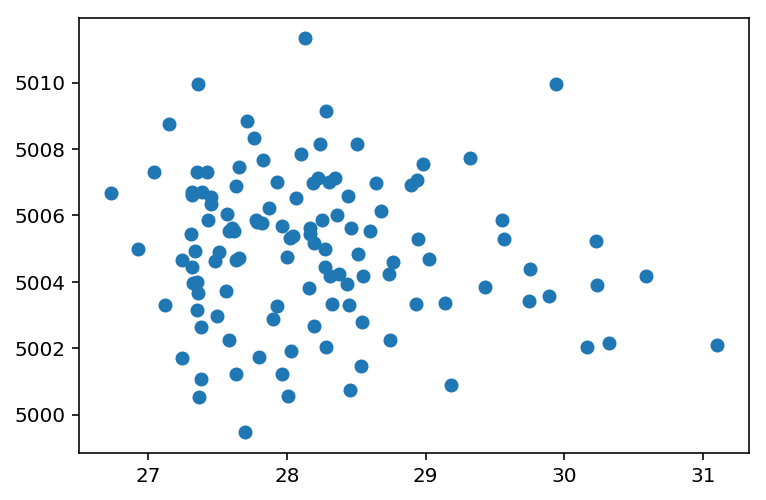

In [46]:
de_z_means = np.array(mean_wave_list[:,0] / (1 + z))
plt.scatter(PNe_df["m 5007"], de_z_means)

## Integrated spectrum with fit

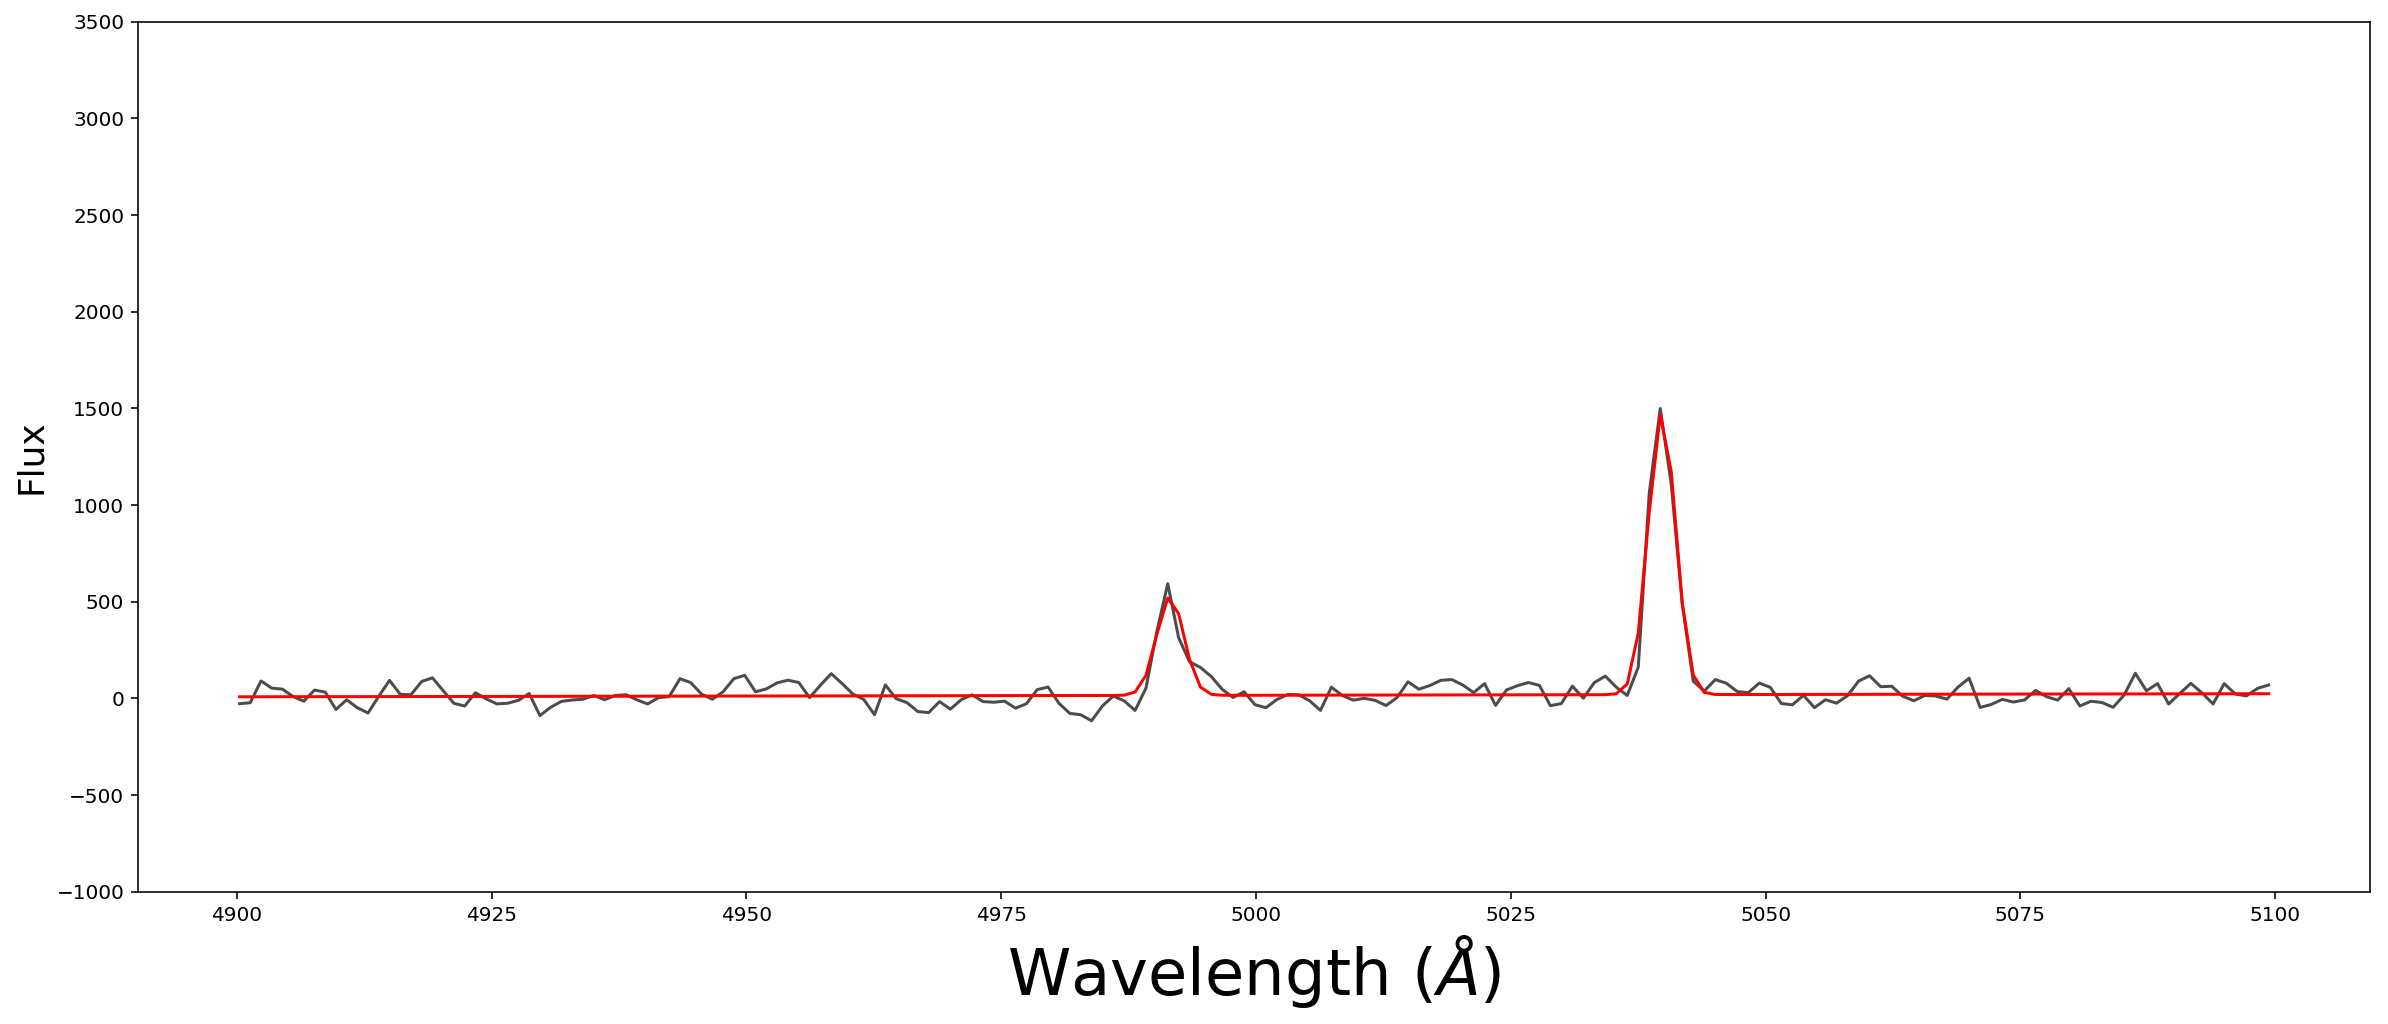

In [47]:
p = 70
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k") # *moff_weight[:,None]

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);
plt.ylim(-1000,3500);
#plt.axvline(5042)
#plt.xlim(4900,5100)
#plt.axvline(5039)
#plt.axvline(5033)

## Spaxel by spaxel with individual fits

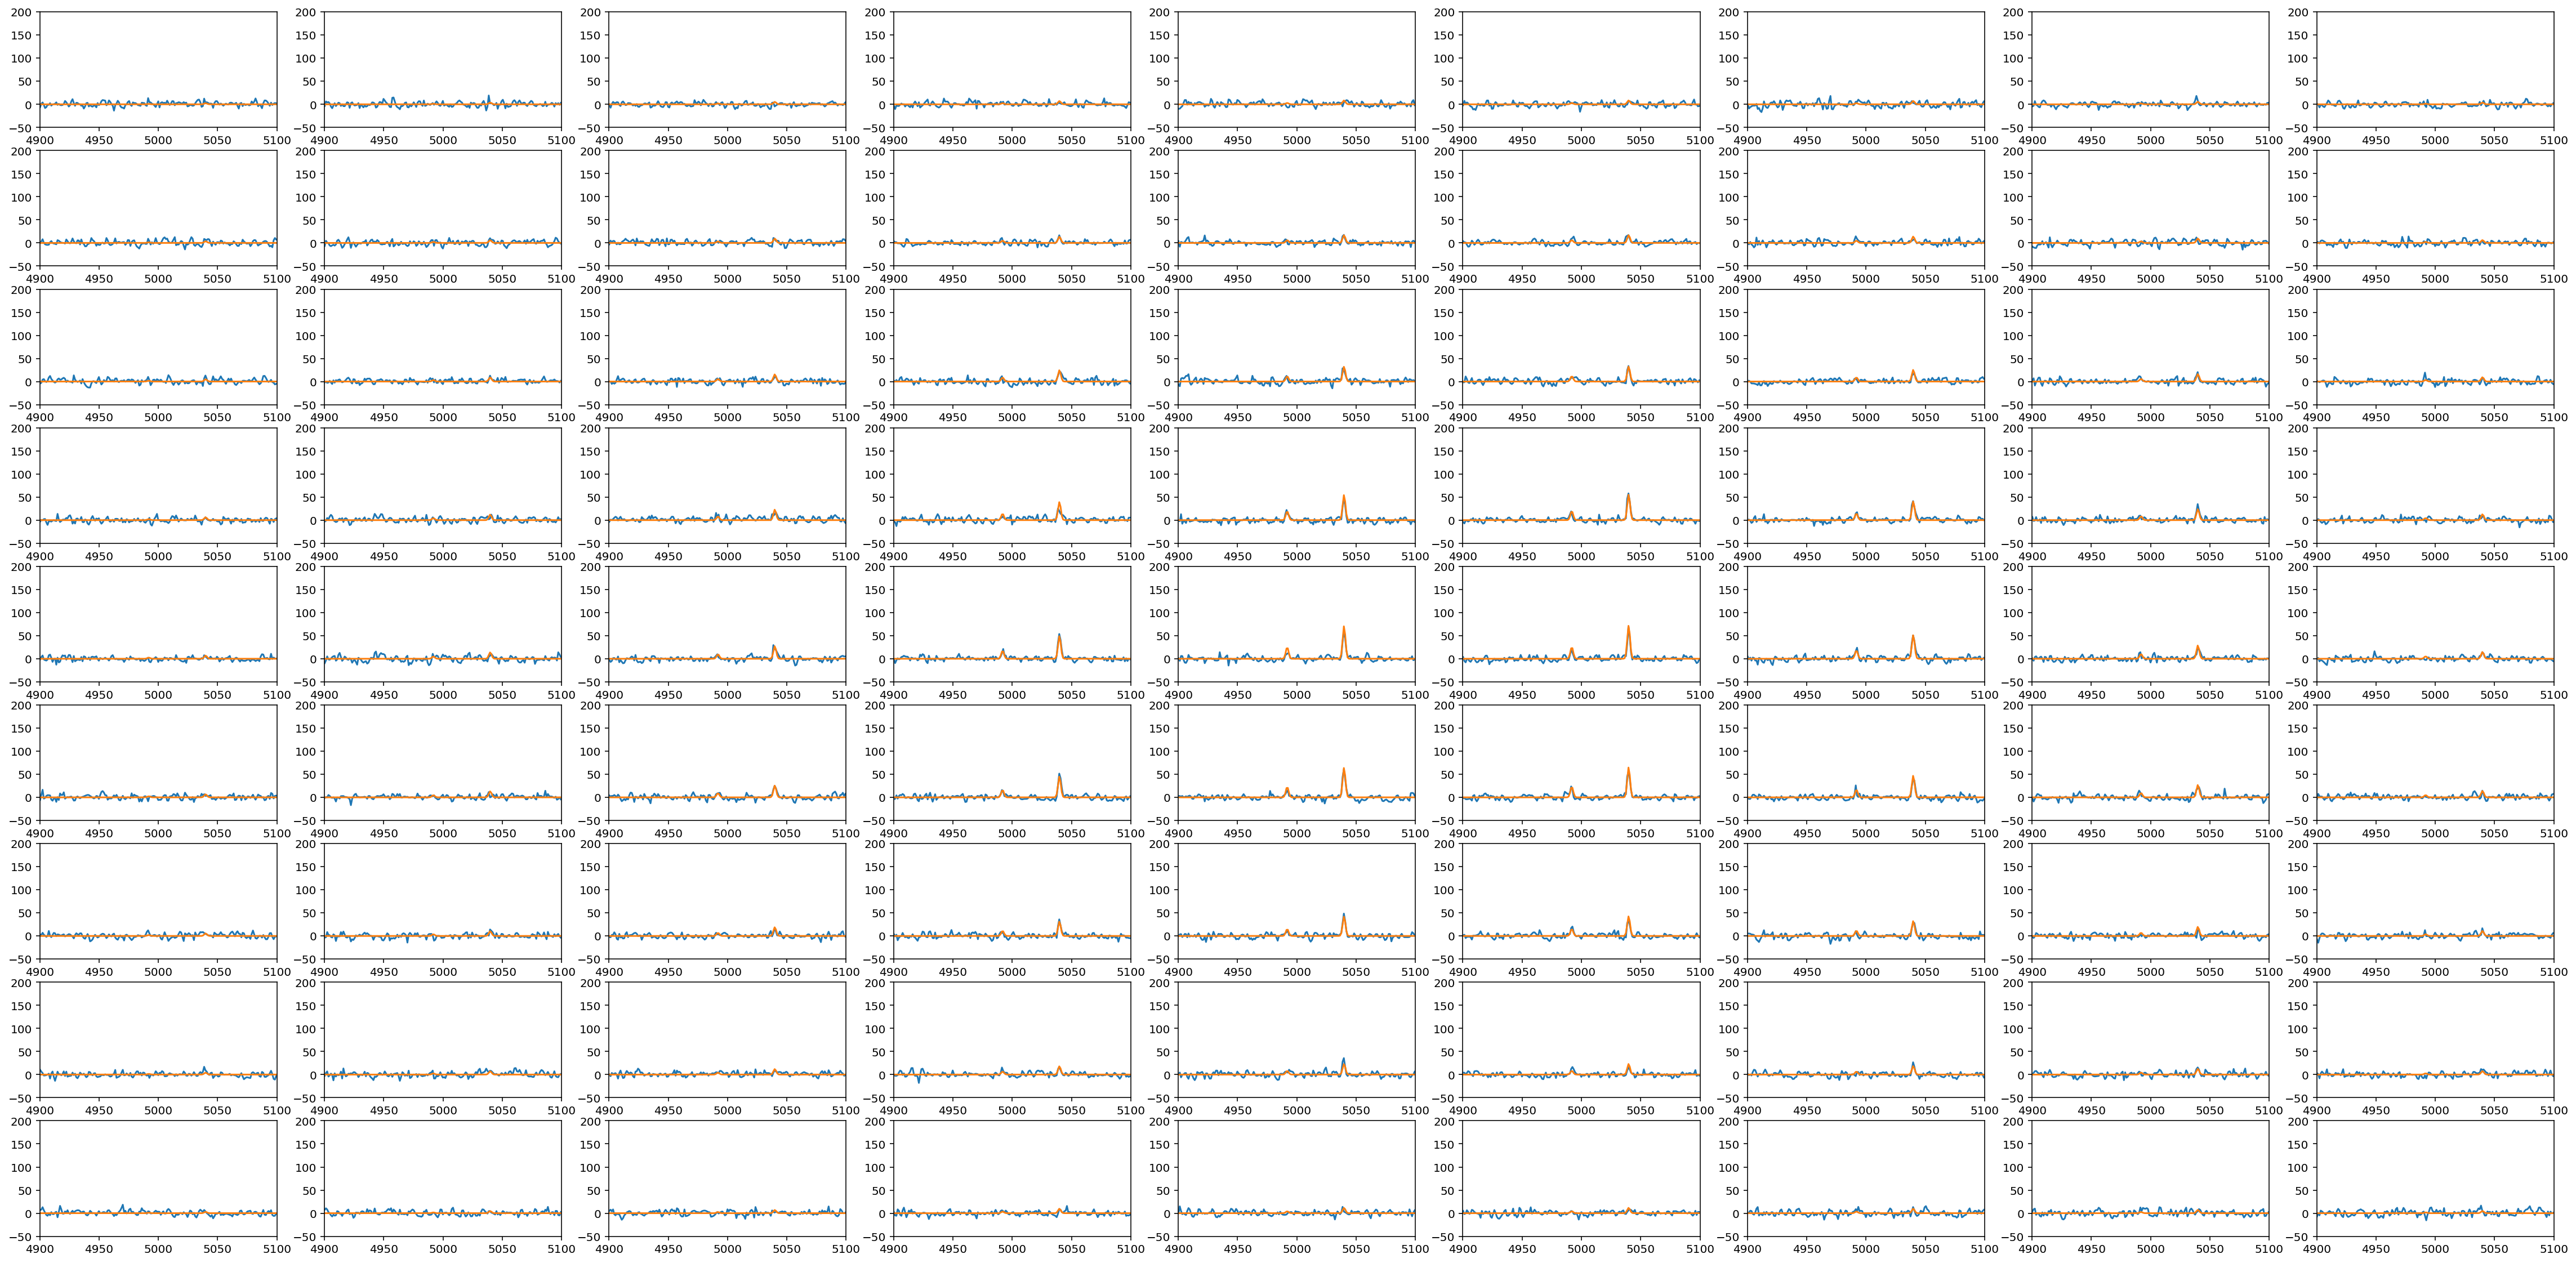

In [40]:
p = 70
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

plt.figure(figsize=(40,20))
for i, spec in enumerate(PNe_n):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.xlim(4900,5100)
    plt.ylim(-50, 200)
    

## [OIII] / Ha   (+[NII])

In [ ]:
OIII_by_Ha = np.load("exported_data/FCC167/OIII_by_Ha.npy")
PNe_df["OIII/Ha"] = OIII_by_Ha
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.scatter(PNe_df["M 5007"], OIII_by_Ha, )
plt.axhline(5)
plt.ylim(0.03,80)
plt.xlim(-6,-2)
x = np.arange(-6, -2,0.001)
plt.plot(x, 10**((-0.37 * x) - 1.16))
plt.ylabel("$I[OIII] \ / \ (I[Ha])$", fontsize="20")
plt.xlabel("$M_{5007}$", fontsize="20")
# plt.savefig("Plots/FCC167/[OIII]Ha+NII.png")

# Load in data and plot FOV

In [23]:
# Pull out the 1D flux data from 1D fits to do radial comparison

gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

#PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
#PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

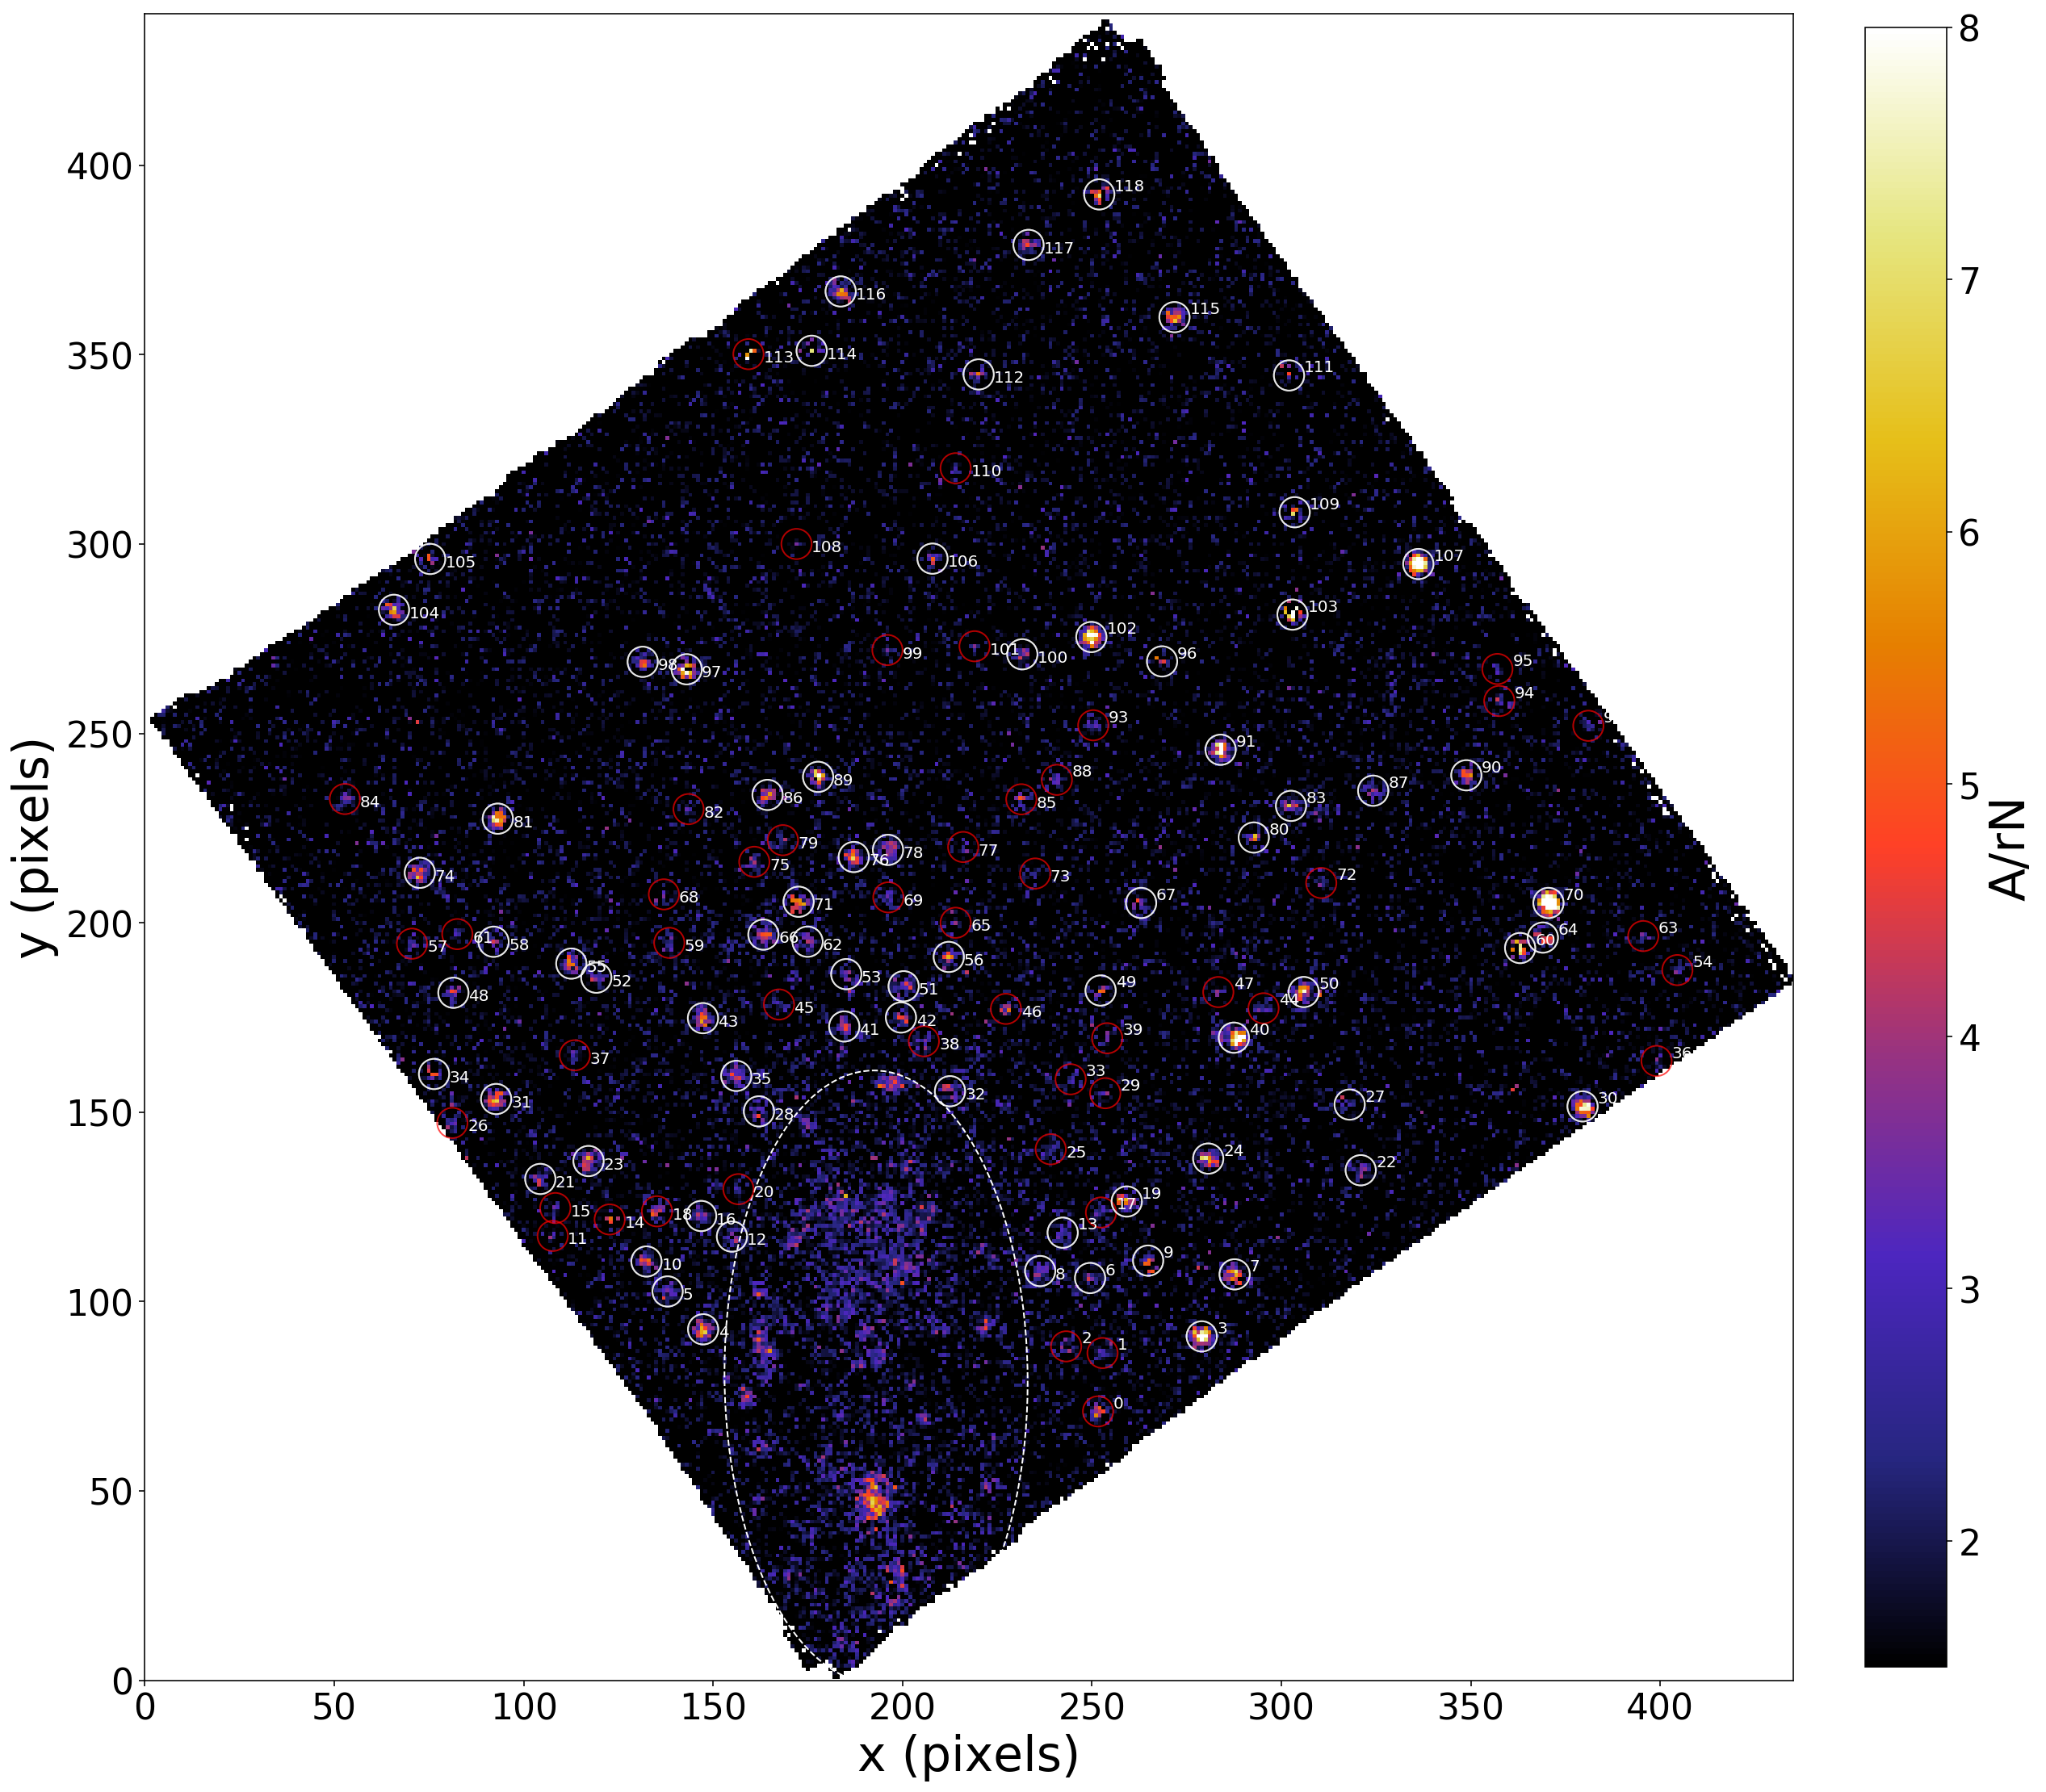

In [24]:

plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

plt.ylim(0,440)
plt.xlim(0,435)

Y, X = np.mgrid[:y_data, :x_data]
if gal_name == "FCC219":
    xe = 193
    ye = 80
    length= 162
    width = 80
    alpha = 0.01
elif gal_name == "FCC167":
    xe = 237
    ye = 206
    length= 180
    width = 75
    alpha = 0.12


elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white", ls="--")
ax.add_artist(elip_gal)

for i, item in enumerate(x_y_list):
    if PNe_df.iloc[i].Filter == "Y":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="white",lw=1.0, fill=False, alpha=0.7)
        ax.add_artist(circ)
    elif PNe_df.iloc[i].Filter == "N":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="red",lw=1.0, fill=False, alpha=0.7)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+4, item[1]-2), color="white", size=10)
    else:
        ax.annotate(i, (item[0]+4, item[1]+1), color="white", size=10)

#plt.axvline(190)
#plt.axhline(110)
# plt.savefig("Plots/"+gal_name+"/A_rN_circled.pdf")

# Scatter points for measured PNe velocity

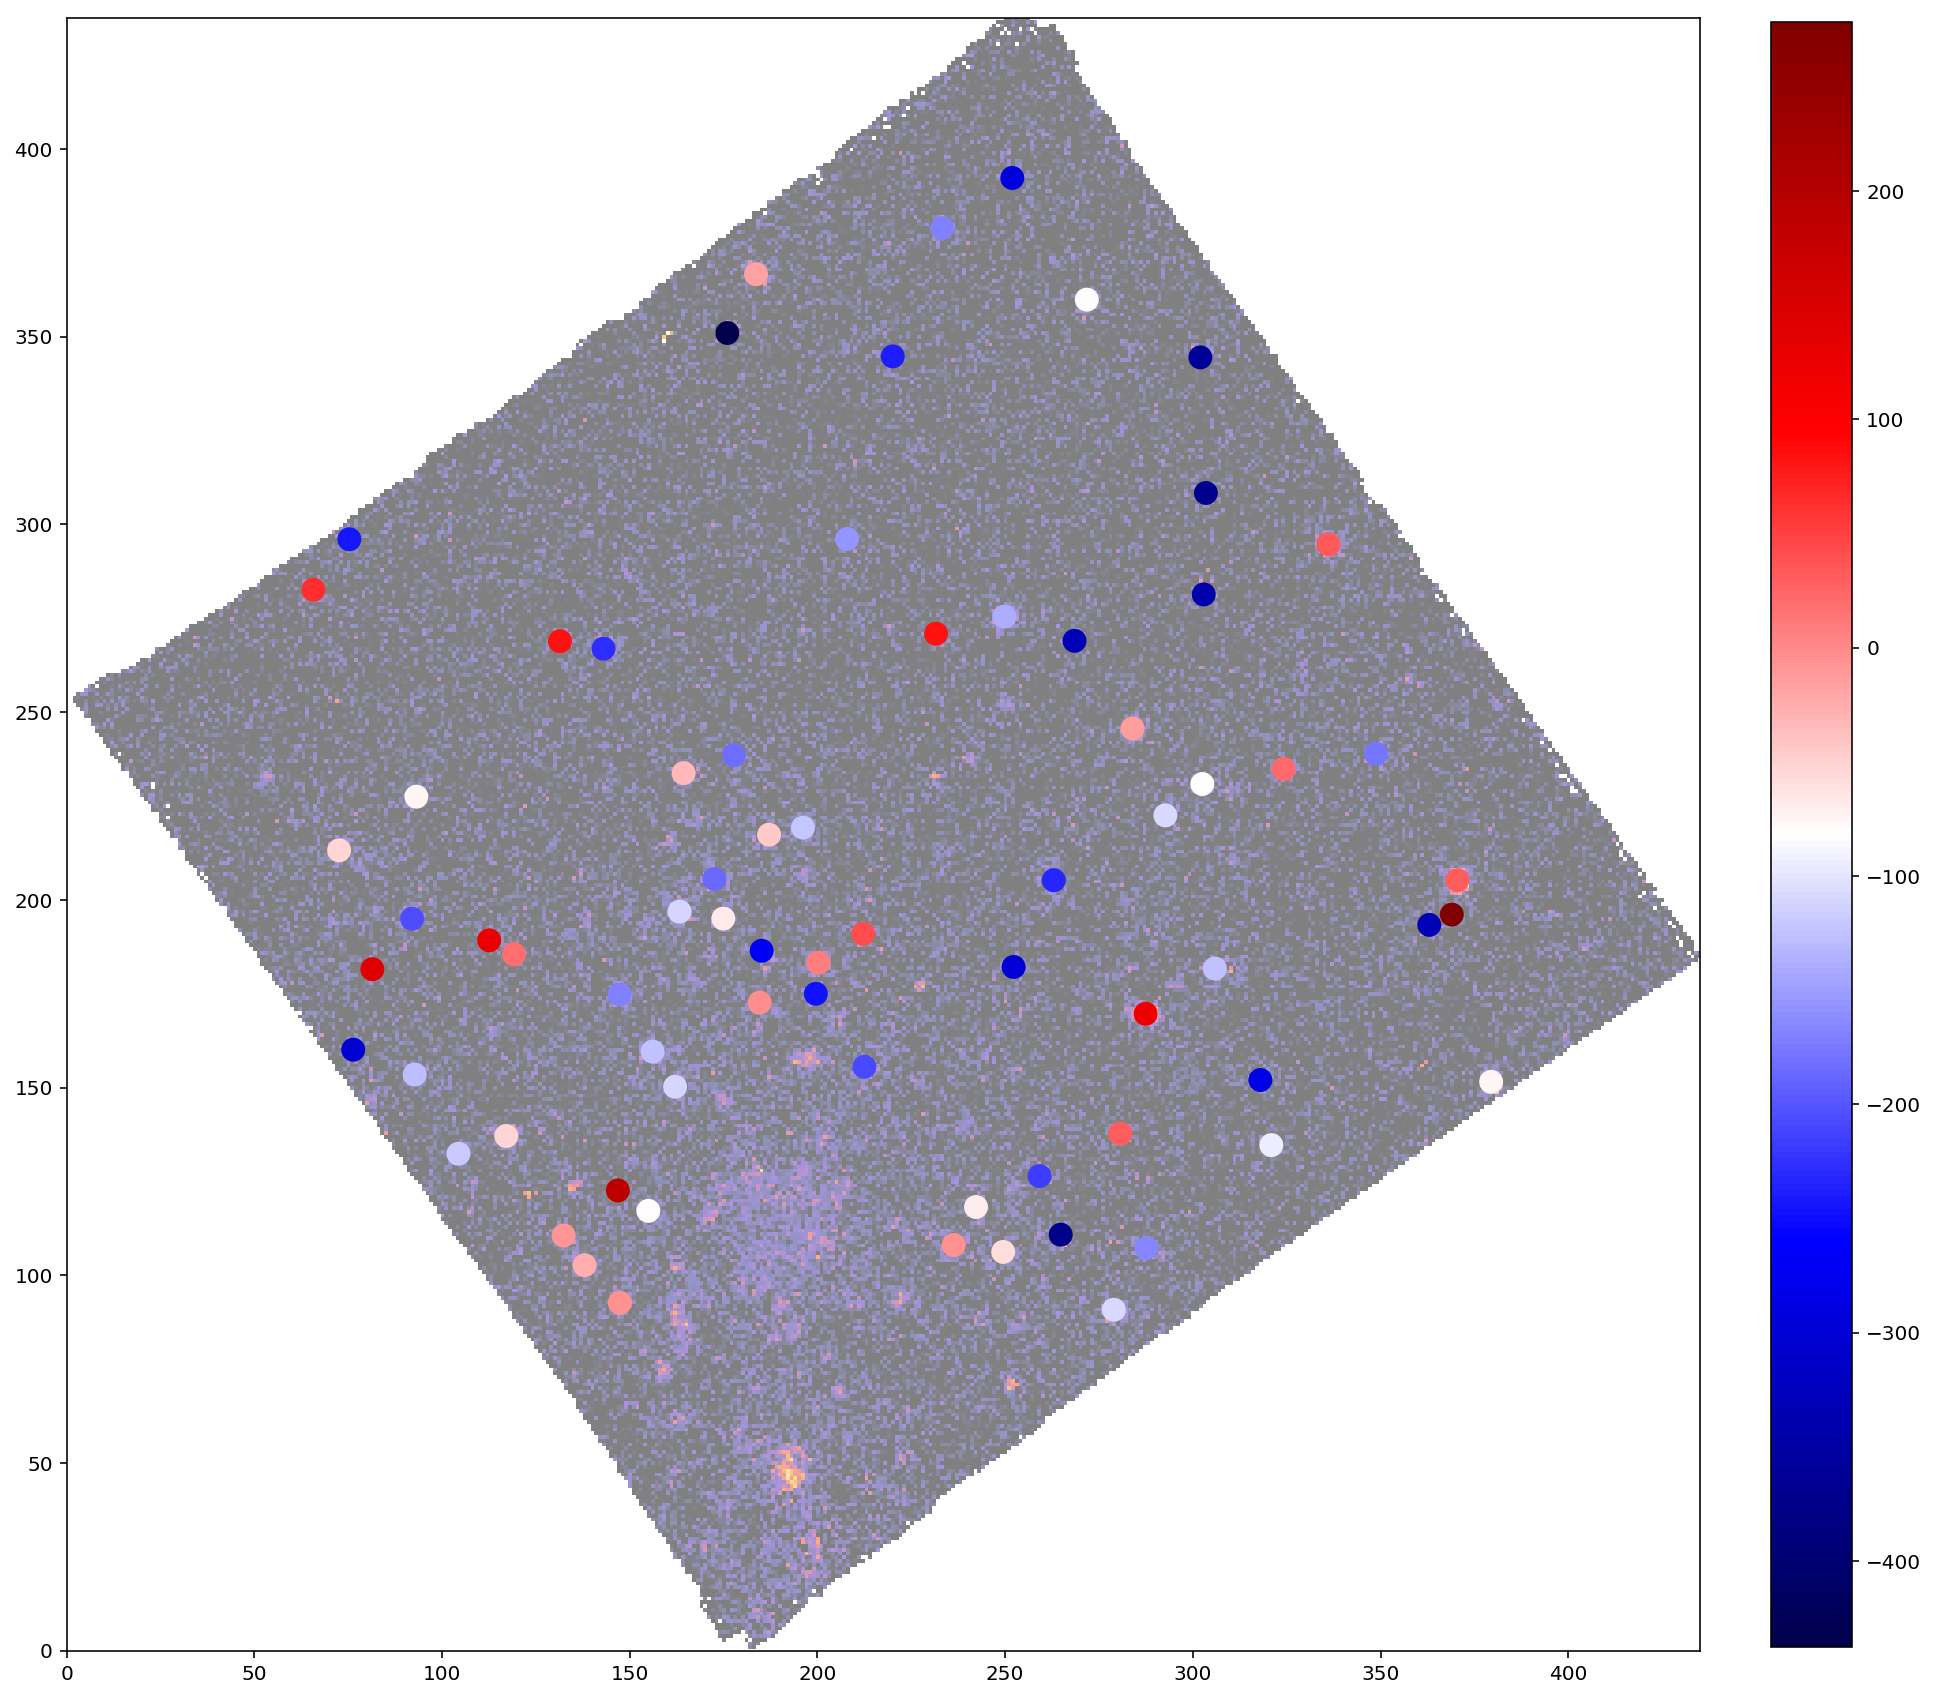

In [48]:
# Scatter plot the x y locations of PNe, colour coding them with their velocity
ind=PNe_df.loc[PNe_df["Filter"]=="Y"].index
positions = (x_PNe[ind], y_PNe[ind])
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8., alpha=0.5)
plt.scatter(x_PNe[ind], y_PNe[ind], c=PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"], cmap="seismic", s=120)
# plt.scatter(x_PNe, y_PNe, c=PNe_df["m 5007"], cmap="inferno_r", s=120)
plt.ylim(0,435)
plt.xlim(0,435)
cb = plt.colorbar(fraction=0.0455, pad=0.04)
# cb.set_label("$V_{[OIII]} \ (km \ s^{-1}$)", fontsize=20)
#plt.savefig("Plots/"+gal_name+"/PNe_velocity_dist_map.pdf")

(29, 26)

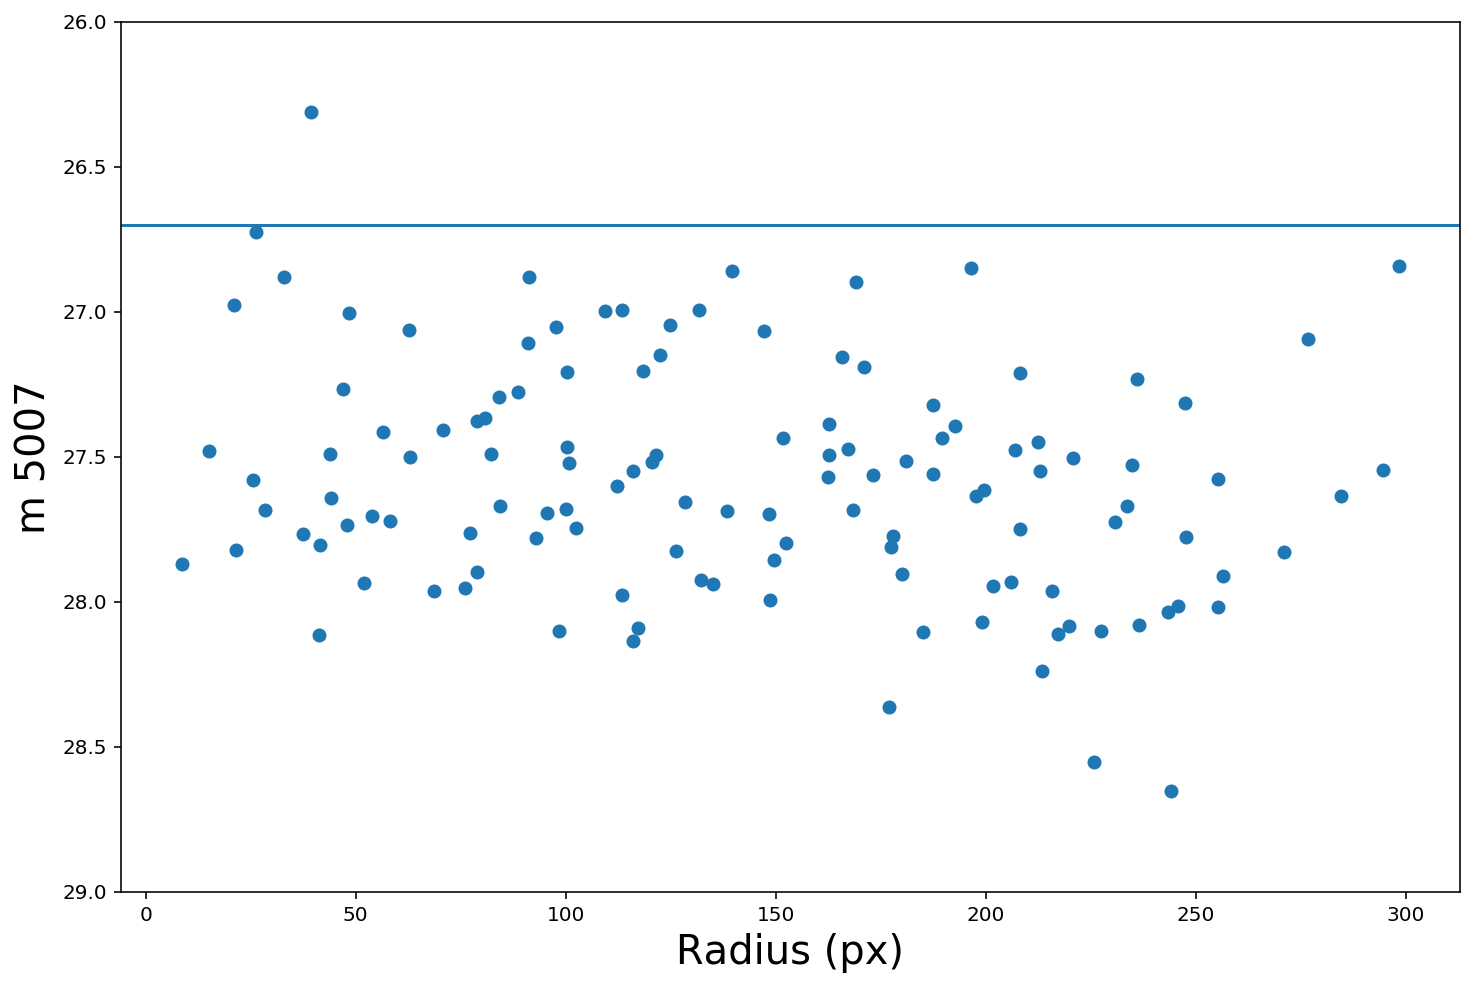

In [11]:
plt.figure(figsize=(12,8))
rad = [np.sqrt((x-190)**2 + (y - 110)**2) for x,y in zip(x_PNe, y_PNe)]
plt.scatter(rad, PNe_df["m 5007"])

plt.axhline(26.7)
plt.ylabel("m 5007", fontsize=20)
plt.xlabel("Radius (px)", fontsize=20)
plt.ylim(29,26)
#plt.savefig("Plots/"+gal_name+"/rad_v_mag.pdf")

In [49]:
## Velocity from files

hdulist_table = fits.open(gal_name+"_data/"+gal_name+"center_table.fits")
X_star, Y_star = hdulist_table[1].data.XBIN, hdulist_table[1].data.YBIN
flux_star = hdulist_table[1].data.FLUX

idx = flux_star.argmax()
X_star, Y_star = X_star-X_star[idx], Y_star-Y_star[idx]

hdulist_ppxf = fits.open(gal_name+"_data/"+gal_name+"center_ppxf_SPAXELS.fits")
v_star, s_star = hdulist_ppxf[1].data.V, hdulist_ppxf[1].data.SIGMA

cond = np.sqrt( (X_star)**2 + (Y_star)**2 ) <= 5.0
vsys = np.average(v_star[cond])
v_star = v_star-vsys

f_ind = PNe_df.loc[PNe_df["Filter"]=="Y"].index
if gal_name == "FCC167":
    gal_x_c = 230
    gal_y_c = 212
elif gal_name == "FCC219":
    gal_x_c = 190
    gal_y_c = 110

xpne, ypne = (x_PNe[f_ind]-gal_x_c)*0.2, (y_PNe[f_ind]-gal_y_c)*0.2

# Estimating the velocity dispersion of the PNe along the LoS
def sig_PNe(X_star,Y_star,v_stars,sigma,x_PNe,y_PNe,vel_PNe):

    d_PNe_to_skin = np.zeros(len(x_PNe))
    Vs_PNe = np.ones(len(x_PNe)) # Velocity of the closest star
    Ss_PNe = np.ones(len(x_PNe)) # Sigma for each PNe
    i_skin_PNe = []

    """ To estimate the velocity dispersion for PNe we need to
    extract the sigma of the closest stars for each PNe """

    for i in range(len(x_PNe)):
        r_tmp = np.sqrt((X_star-x_PNe[i])**2+(Y_star-y_PNe[i])**2)
        d_PNe_to_skin[i] = min(r_tmp)
        i_skin_PNe.append(r_tmp.argmin())

    Vs_PNe  = v_stars[i_skin_PNe]
    Ss_PNe  = sigma[i_skin_PNe]
    rad_PNe = np.sqrt(x_PNe**2+y_PNe**2)
    k = np.where(d_PNe_to_skin > 1.0)

    return rad_PNe, (vel_PNe-Vs_PNe)/Ss_PNe, k

rad_PNe, vel_ratio, k  = sig_PNe(X_star, Y_star, v_star, s_star, xpne, ypne, PNe_df["V (km/s)"].loc[PNe_df["Filter"]=="Y"])


(-5, 5)

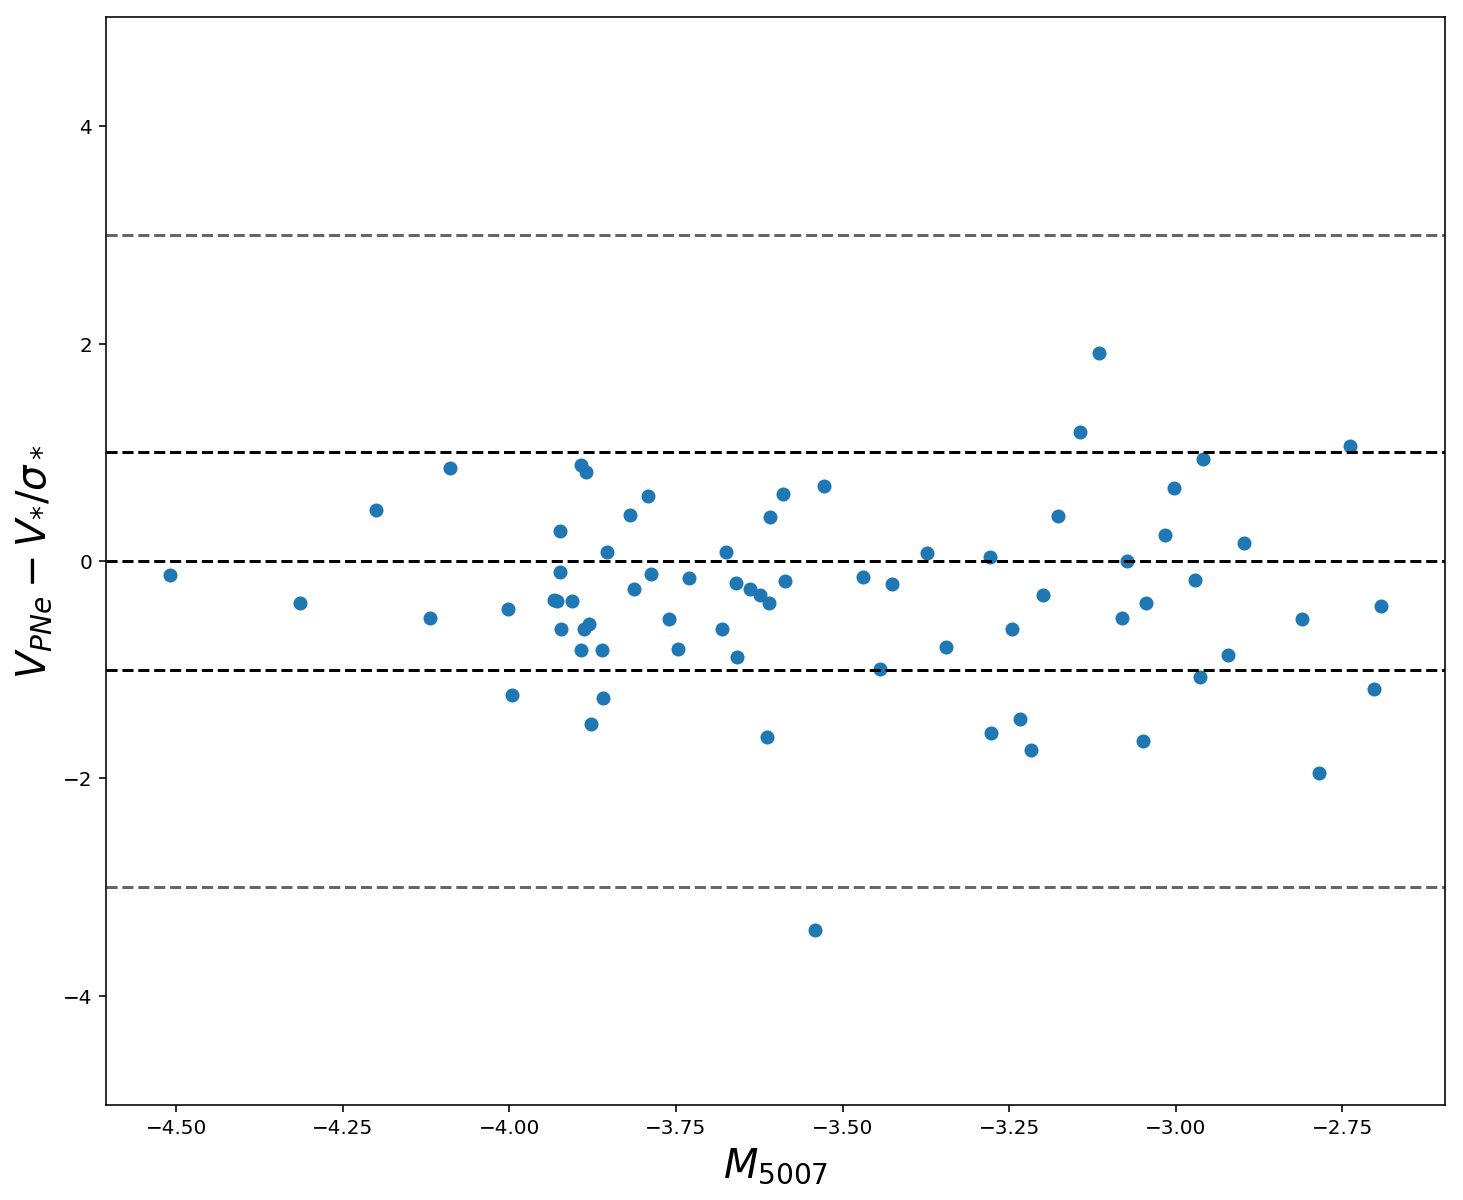

In [50]:
plt.figure(44, figsize=(12,10))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"], vel_ratio)
plt.xlabel("$M_{5007}$", fontsize=20)
plt.ylabel("$V_{PNe} - V_{*} / \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=3, c="k", ls="dashed", alpha=0.6)
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.axhline(y=-3, c="k", ls="dashed", alpha=0.6)
plt.ylim(-5,5)
#plt.xlim(-5,-2)

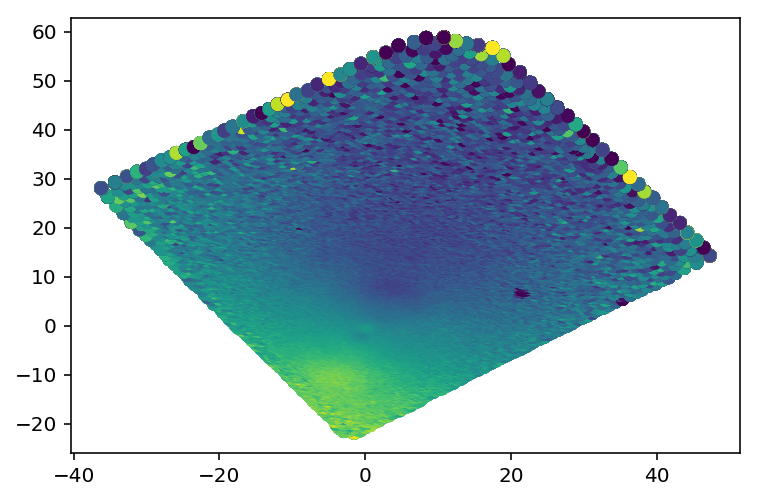

In [60]:
plt.scatter(X_star, Y_star, c=v_star, vmin=-150, vmax=150)
plt.scatter(xpne,ypne,c=PNe_df['V (km/s)'])
plt.colorbar()

# SEP - Source Detection

119


<Figure size 1440x1440 with 0 Axes>

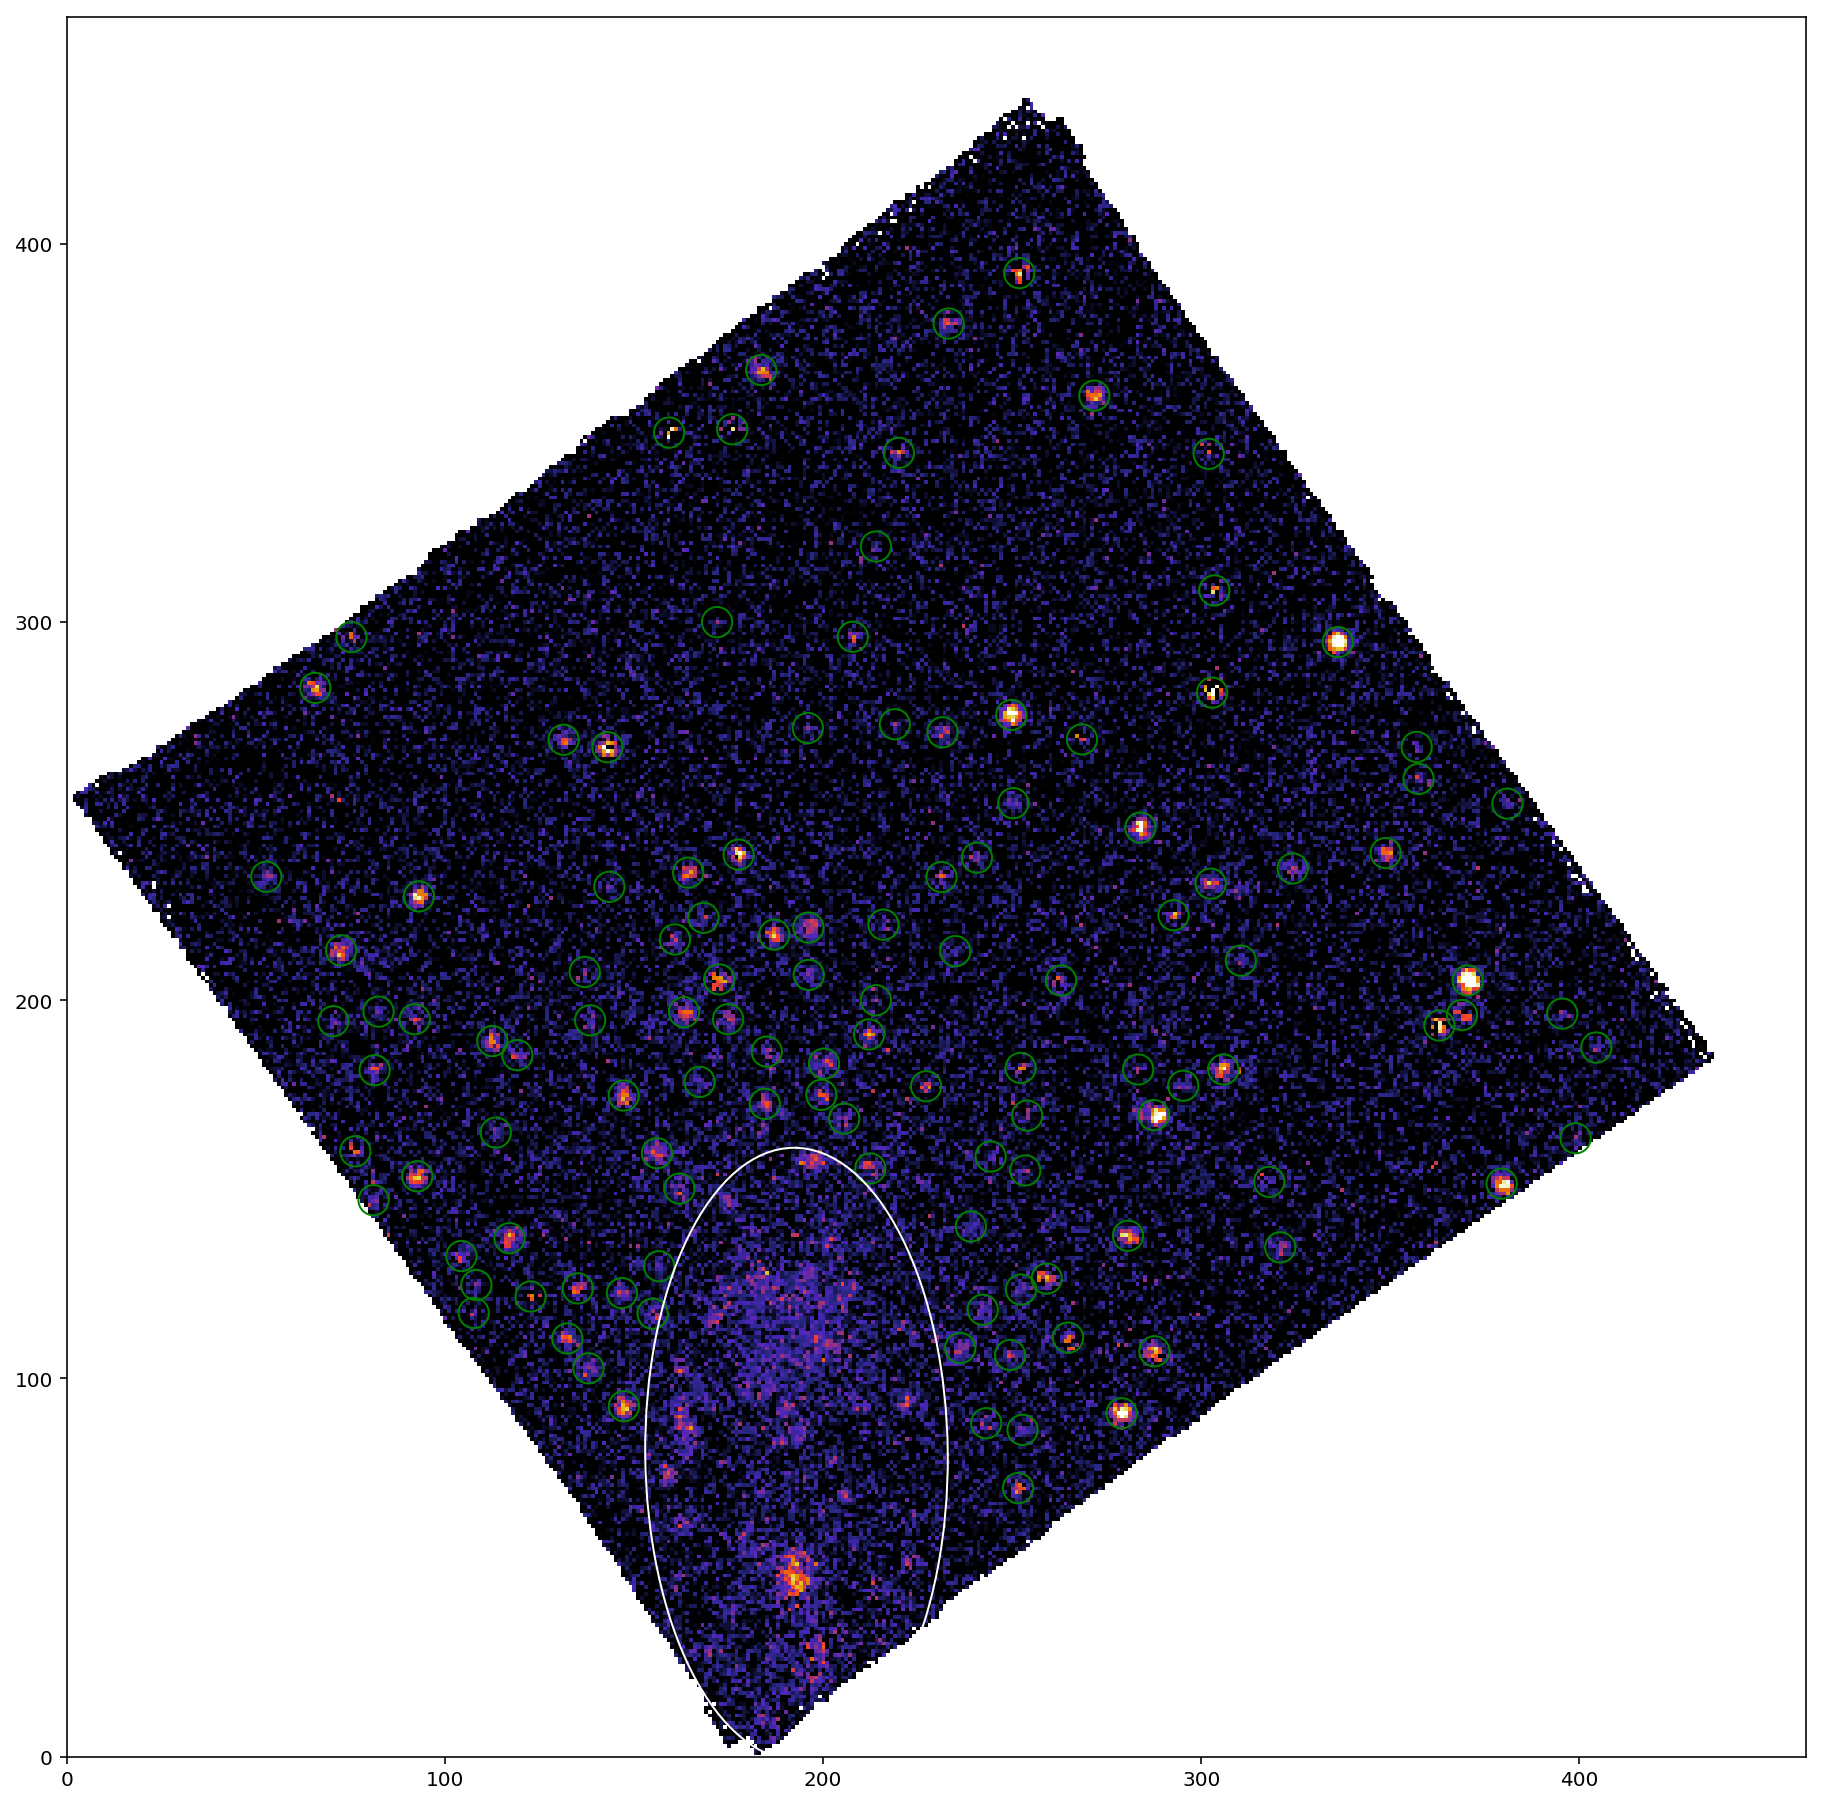

In [131]:
A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

Y, X = np.mgrid[:y_data, :x_data]
if gal_name == "FCC219":
    xe = 193
    ye = 80
    length= 162
    width = 80
    alpha = 0.01
elif gal_name == "FCC167":
    xe = 237
    ye = 206
    length= 180
    width = 75
    alpha = 0.12


elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1    

objects = sep.extract(A_rN_plot_shape, thresh=2.0, clean=True, minarea=1, mask=elip_mask_gal, maskthresh=1.0)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
apertures.plot(color="green")

ax = plt.gca()

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
ax.add_artist(elip_gal)


sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
plt.xlim(0,460)
plt.ylim(0,460)
print(len(x_sep))

#np.save("exported_data/"+gal_name+"/PNe_x_y_list", sep_x_y_list)

# PSF

[ 70 107 103 102   3  40  91  60  97 114]
FWHM:  4.070557707466462 +/- 0.05837356572177276 (1.43%)
Beta:  2.5500854983327823 +/- 0.2353035214812556 (9.23%)
LSF:  3.132561244846881 +/- 0.02879844524711911 (0.92%)




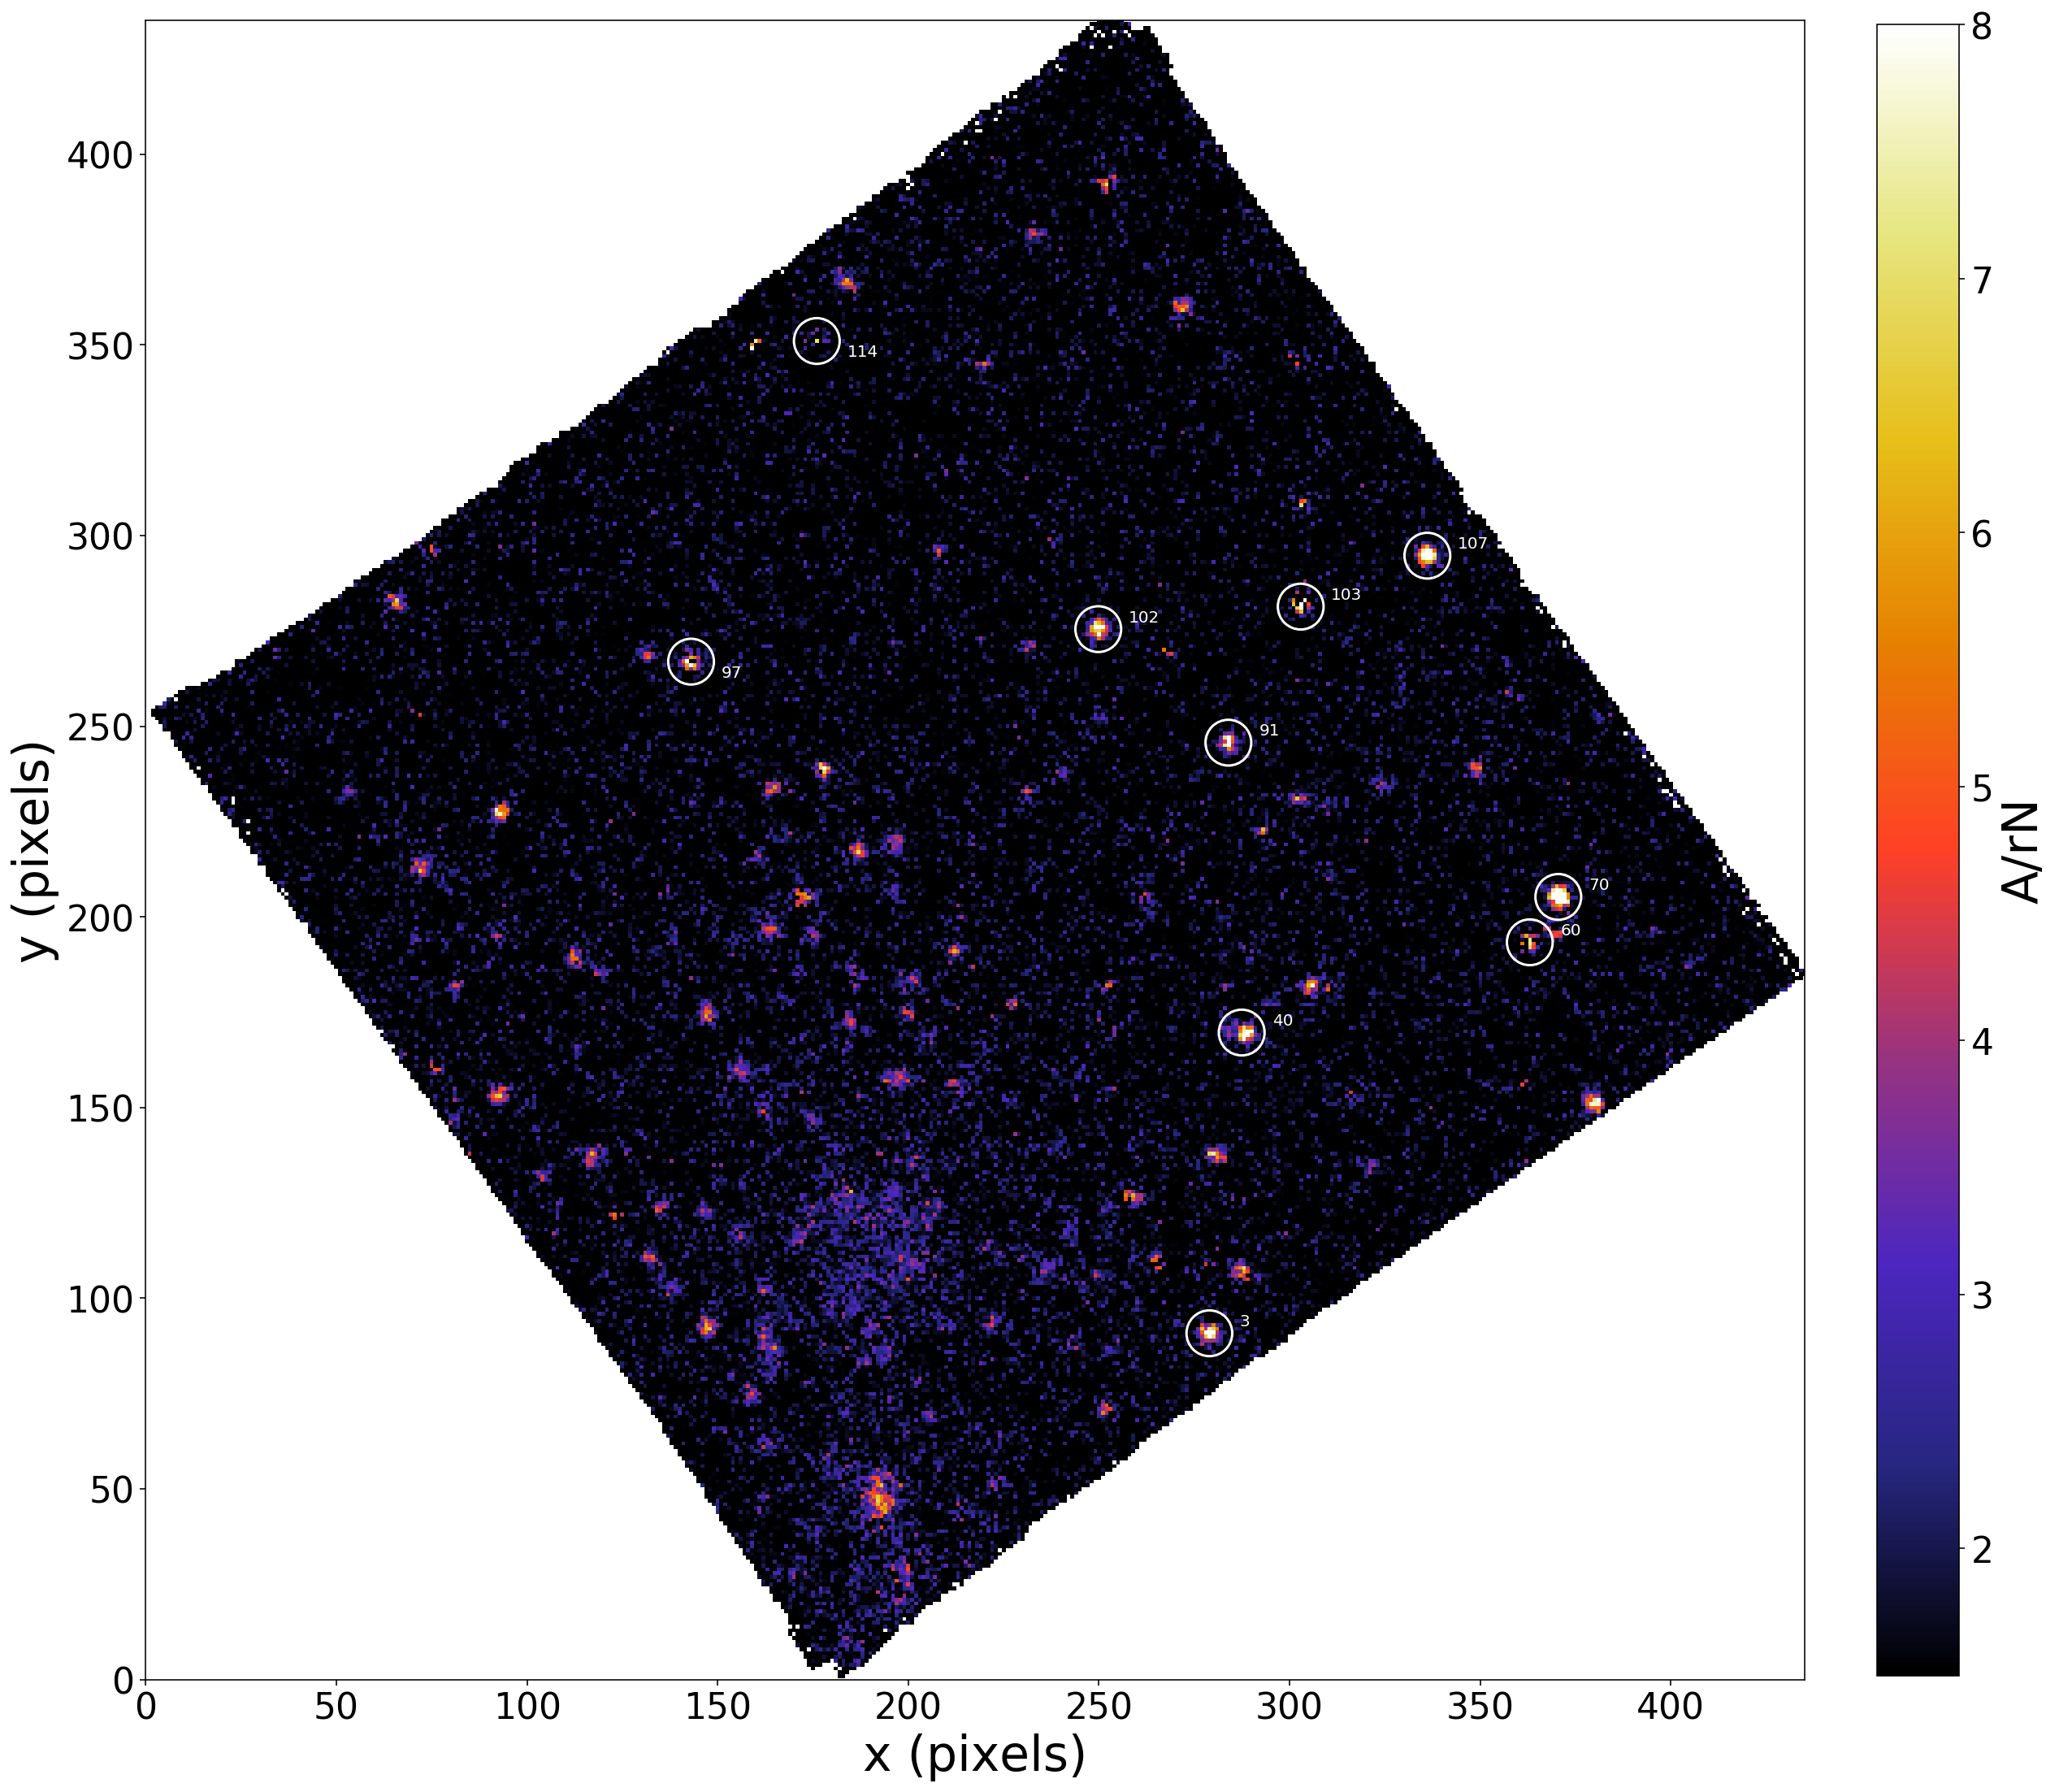

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 973
    # data points      = 151470
    # variables        = 43
    chi-square         = 5155364.52
    reduced chi-square = 34.0452133
    Akaike info crit   = 534382.114
    Bayesian info crit = 534809.024
[[Variables]]
    moffat_amp_000:  227.136704 +/- 4.61977337 (2.03%) (init = 200)
    x_000:           4.26341761 +/- 0.04565036 (1.07%) (init = 4.5)
    y_000:           4.54170285 +/- 0.04537585 (1.00%) (init = 4.5)
    wave_000:        5039.83881 +/- 0.03053827 (0.00%) (init = 5039.535)
    gauss_bkg_000:   0 (fixed)
    gauss_grad_000:  0 (fixed)
    moffat_amp_001:  171.154451 +/- 4.23024655 (2.47%) (init = 200)
    x_001:           3.78471199 +/- 0.06081051 (1.61%) (init = 4.5)
    y_001:           4.08518194 +/- 0.06024345 (1.47%) (init = 4.5)
    wave_001:        5039.85514 +/- 0.04046938 (0.00%) (init = 5039.535)
    gauss_bkg_001:   0 (fixed)
    gauss_grad_001:  0 (fixed)
    moffat_amp_002:  17

In [148]:
### Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
if gal_name == "FCC167":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 122].nlargest(5, "A/rN").index.values
elif gal_name == "FCC219":
    sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 30].nlargest(10, "A/rN").index.values

#sel_PNe = PNe_df.loc[PNe_df["PNe number"] != 1].nlargest(10, "A/rN").index.values

# sel_PNe = [41]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe]
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.01)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-50., max=mean+50.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.000, vary=False)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.000, vary=False)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5007*(1+z))    
    
PSF_params.add('FWHM', value=4.0,  min=0.01, vary=True)
PSF_params.add("beta", value=2.5,  min=0.01, vary=True) 
PSF_params.add("LSF",  value=2.81,)# min=0.01, vary=True)

PSF_results = minimize(PSF_residuals_3D, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ", PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr / PSF_results.params["FWHM"].value)*100) )
print("Beta: ", PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr / PSF_results.params["beta"].value)*100) )
print("LSF: " , PSF_results.params["LSF"].value , "+/-", PSF_results.params["LSF"].stderr,  "({:3.2f}%)".format((PSF_results.params["LSF"].stderr  / PSF_results.params["LSF"].value)*100)  )
print("\n")

# Plot locations of PNe used for PSF
plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

plt.ylim(0,435)
plt.xlim(0,435)

for (i, item), n in zip(enumerate(x_y_list[sel_PNe]), sel_PNe):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white",lw=1.5, fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(n, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(n, (item[0]+8, item[1]+2), color="white", size=10)
plt.show()
print(report_fit(PSF_results, show_correl=False))


### FCC219
FWHM:  4.070557707466462 +/- 0.05837356572177276 (1.43%)
Beta:  2.5500854983327823 +/- 0.2353035214812556 (9.23%)
LSF:  3.132561244846881 +/- 0.02879844524711911 (0.92%)


## FCC167 
[124  36  24  28 121]
FWHM:  3.732829642857893 +/- 0.08724275335913244 (2.34%)
Beta:  1.5713478914180656 +/- 0.1304137400764402 (8.30%)
LSF:  3.294684009911774 +/- 0.04344903609551863 (1.32%)

## Comparison with literature

In [61]:
gal_hdulist = fits.open(gal_name+"_data/"+gal_name+"center.fits")

x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

hdr_wcs = gal_hdulist[1].header
wcs_obj = WCS(hdr_wcs, naxis=2)

for i in np.arange(0, len(x_PNe)):
    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms").split()
    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

## FCC167

In [51]:
c = ascii.read("NGC1380_PNe_from_paper.txt", data_start=1)
lit_RA = list(c["RA"])
lit_Dec = list(c["Dec"])
lit_m = np.array(c["mag"])

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(lit_RA)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(lit_RA[i], u.hourangle), dec=Angle(lit_Dec[i], u.deg), frame="fk5"), wcs_obj)

smallest_sep = []
for r,d in zip(lit_RA, lit_Dec):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
#print(indx[[0,2,6,20]])
#print(lit_m[[0,2,6,20]])
PNe_df.loc[indx[np.where(diff<0.001)]]

[0.0001147  0.00099191 0.00032357 0.00041565 0.00027396]
(array([ 0,  1,  2,  6, 20]),)


PNe number      Ra (J2000)      Dec (J2000)    V (km/s)     m 5007  \
105         105  03h36m27.6516s  -34d58m00.2475s -162.572831  27.870699   
107         107  03h36m28.2602s  -34d57m57.1921s -145.570366  27.659577   
93           93  03h36m28.0016s  -34d58m14.8502s -110.938476  26.852739   
66           66  03h36m26.3736s  -34d58m29.4728s   12.141866  27.159870   
85           85  03h36m25.6455s  -34d58m18.9537s  -99.128209  27.535839   

       M 5007   [OIII] Flux M 5007 error      A/rN rad D    redchi Filter  \
105 -3.760980  2.268404e-17          NaN  4.177366   NaN  1.031042      Y   
107 -3.972102  2.755302e-17          NaN  3.353217   NaN  1.022538      Y   
93  -4.778940  5.793010e-17          NaN  7.411431   NaN  1.022187      Y   
66  -4.471809  4.365681e-17          NaN  6.180837   NaN  1.026172      Y   
85  -4.095841  3.087909e-17          NaN  5.811747   NaN  1.032757      Y   

     [OIII]/Hb    Flux error  F[OIII] err percent    OIII/Ha  
105   6.335699  1.300286e-18             5.732164   4.407040  
107   4.995429  1.805498e-18             6.552813   0.000000  
93    3.922341  2.214920e-18             3.823436   9.842604  
66    8.170374  1.930254e-18             4.421427   8.790239  
85    5.690026  1.385662e-18             4.487380  11.094197

In [68]:
print(PNe_df["[OIII] Flux"].loc[indx[[ 0,  1,  2,  6, 20]]].values)
print([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866])
print(lit_m[[ 0,  1,  2,  6, 20]])
print(np.abs([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866] - lit_m[[ 0,  1,  2,  6, 20]]))

[2.26840373e-17 2.75530161e-17 5.79301040e-17 4.36568107e-17
 3.08790930e-17]
[27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866]
[26.585 26.718 26.725 26.809 27.203]
[0.53696    0.94157713 0.12773923 0.35086999 0.33283866]


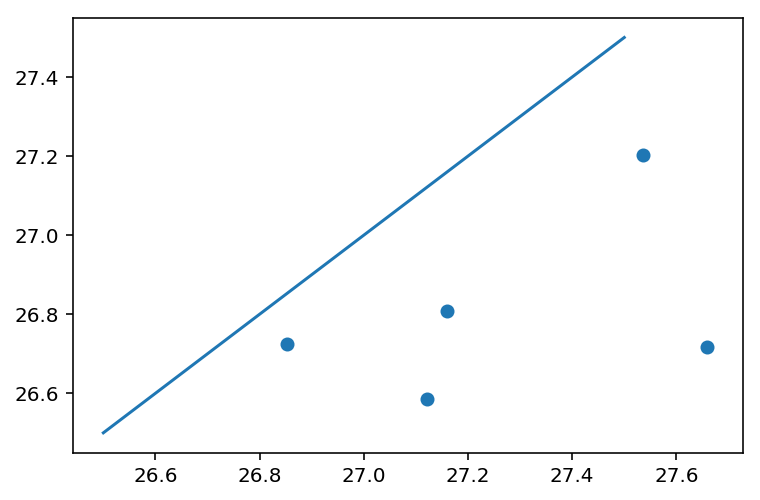

In [61]:
plt.scatter([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866], lit_m[[ 0,  1,  2,  6, 20]] )
plt.plot(np.arange(26.5,28), np.arange(26.5,28))

Text(0, 0.5, 'Dec')

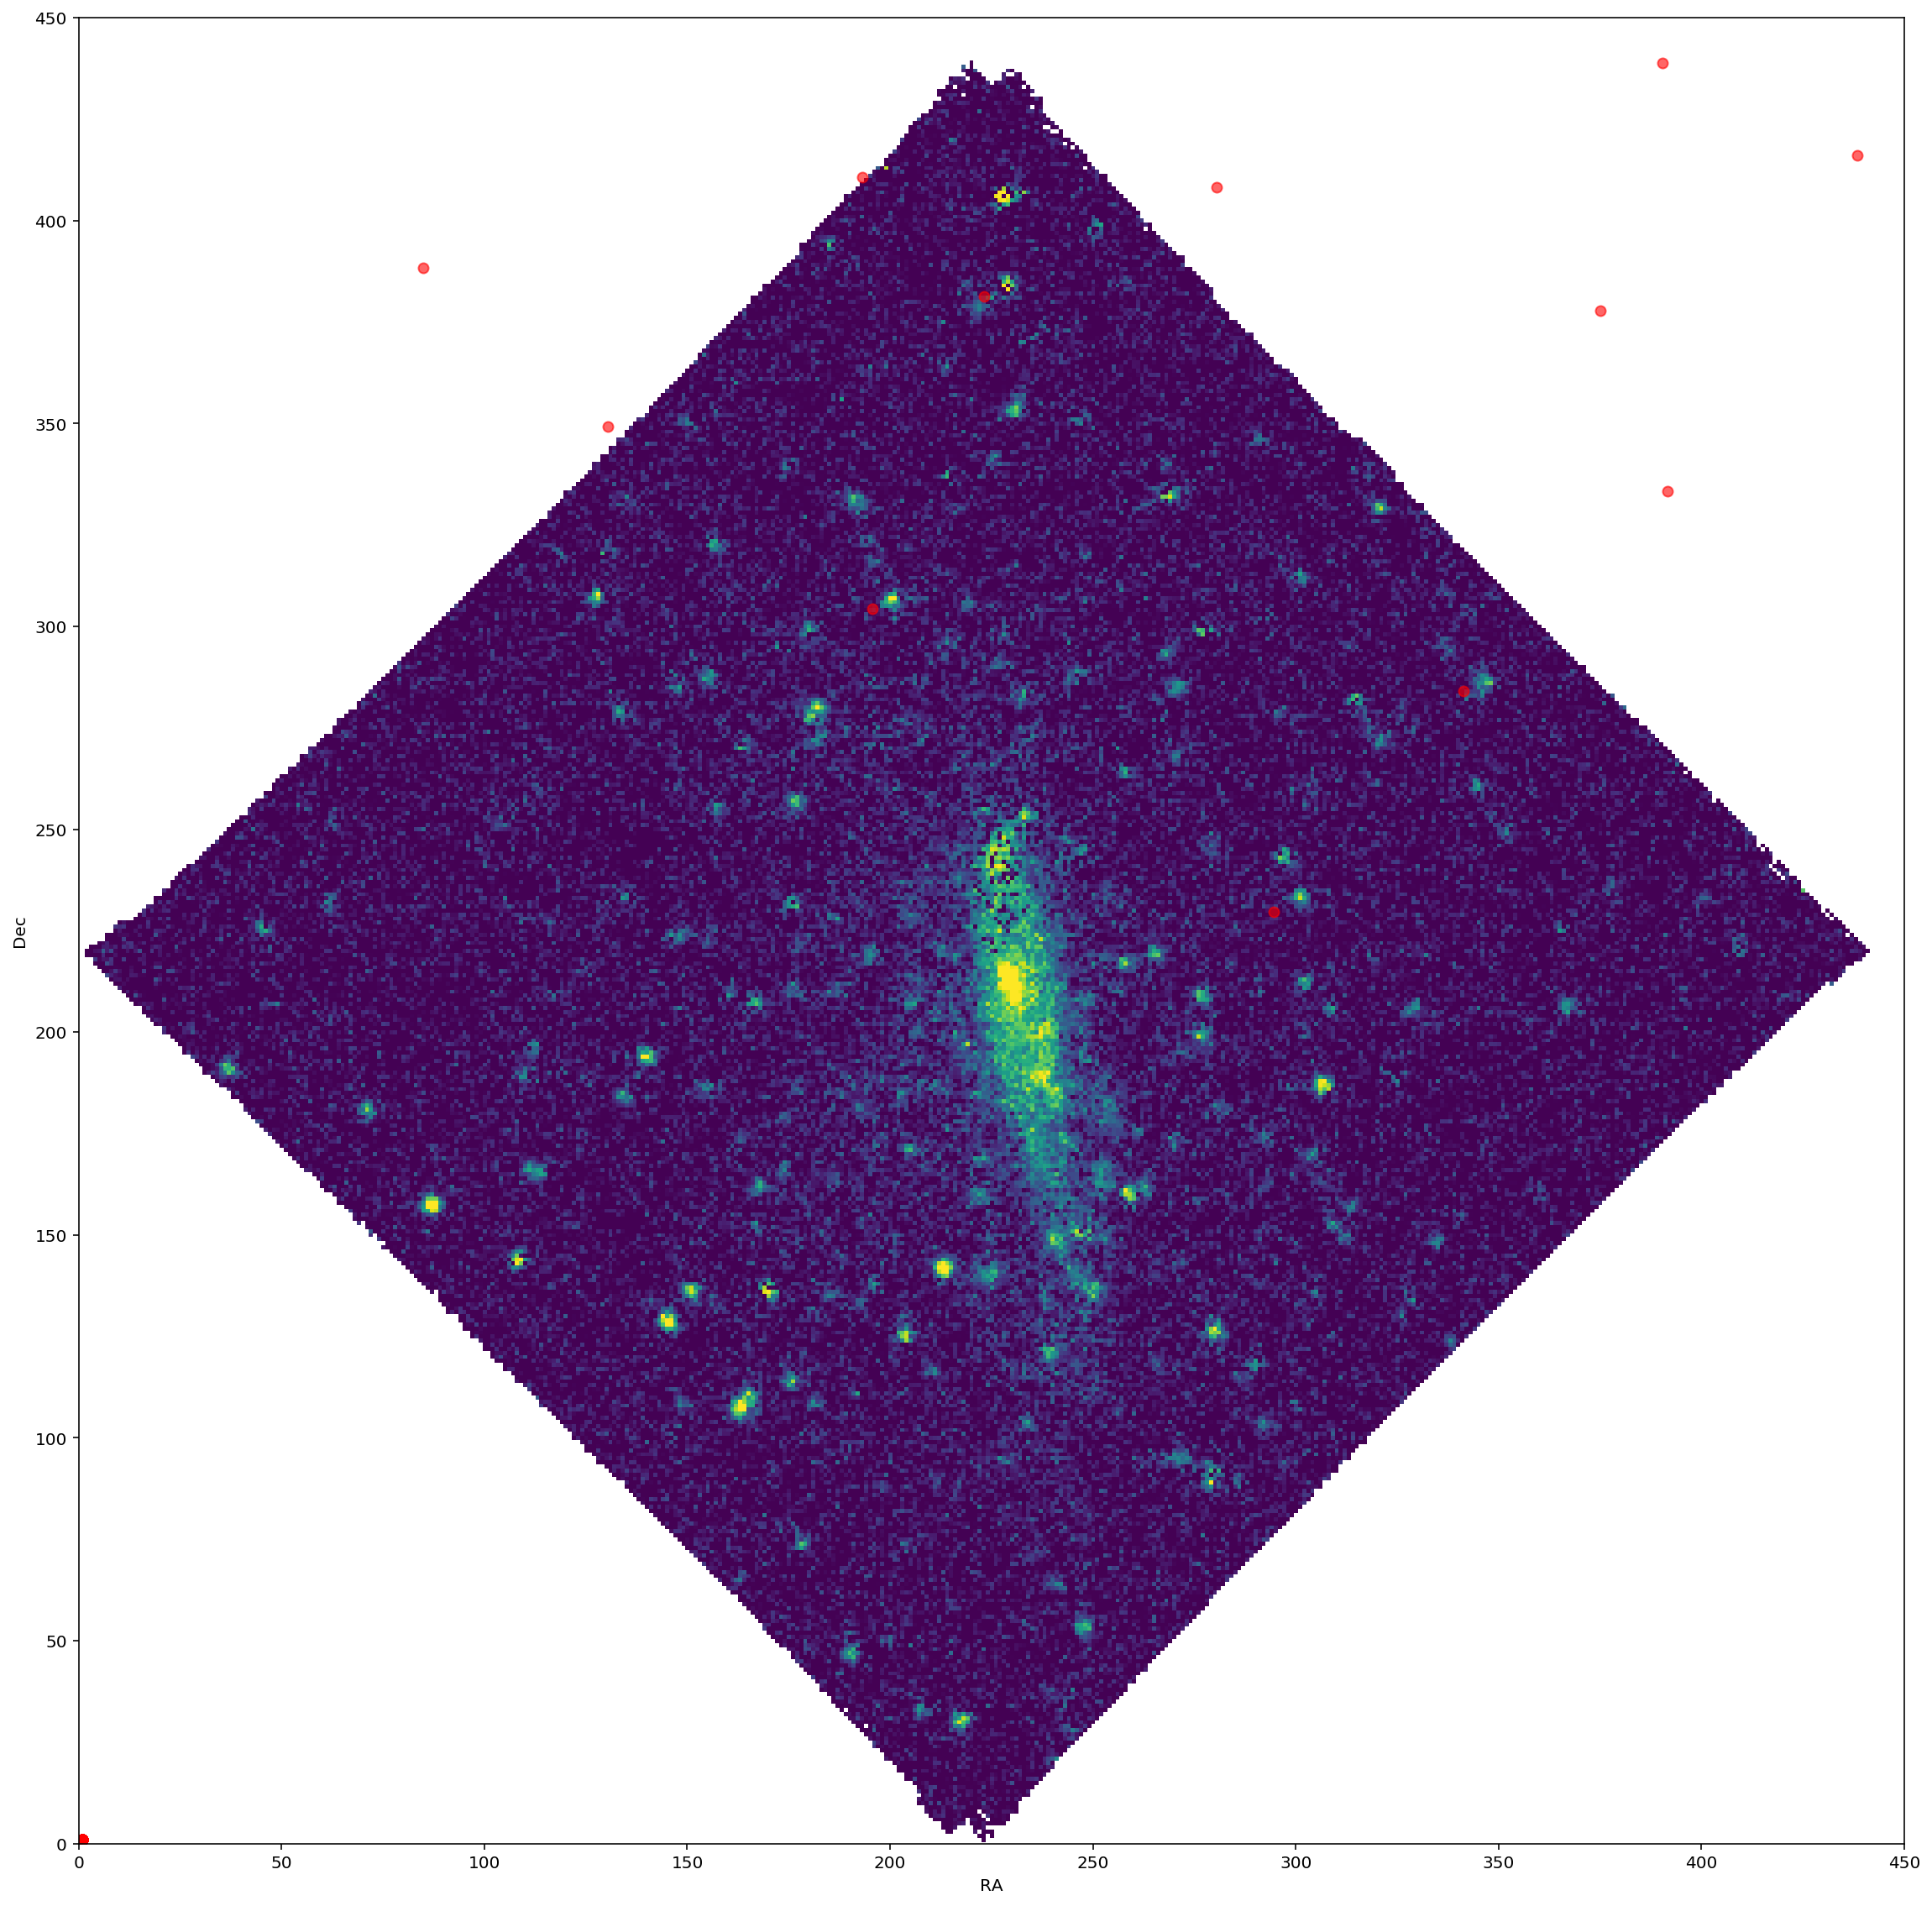

In [40]:
gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
plt.xlim(0,450)
plt.ylim(0,450)
plt.xlabel('RA')
plt.ylabel('Dec')

## FCC219

[0.00027301 0.00022469 0.00024347 0.00022385 0.00019106 0.00024302]
(array([ 2,  4,  7, 31, 38, 43]),)
[ 61  65 104 115 106 108]


PNe number      Ra (J2000)      Dec (J2000)    V (km/s)     m 5007  \
61           61  03h38m49.0891s  -35d35m23.1532s -345.749869  27.594658   
65           65  03h38m48.9907s  -35d35m22.6009s  259.714851  28.093634   
104         104  03h38m50.0742s  -35d35m05.5478s -355.745398  27.353643   
115         115  03h38m52.1549s  -35d34m51.6173s -451.130710  27.669189   
106         106  03h38m53.8059s  -35d35m02.6063s -259.321397  28.158646   
108         108  03h38m49.5297s  -35d35m02.8763s   19.354254  27.316820   

       M 5007   [OIII] Flux M 5007 error       A/rN rad D    redchi Filter  \
61  -3.613009  2.925075e-17          NaN   7.341989   NaN  1.004045      Y   
65  -3.114033  1.847339e-17          NaN   4.815129   NaN  1.016195      Y   
104 -3.854023  3.652100e-17          NaN   9.963678   NaN  1.000426      Y   
115 -3.538478  2.731017e-17          NaN   7.054721   NaN  1.005559      Y   
106 -3.049021  1.739970e-17          NaN   4.337599   NaN  1.173099      Y   
108 -3.890847  3.778087e-17          NaN  10.563127   NaN  0.990047      Y   

             Chi2    [OIII]/Hb    Flux error  m 5007 error  \
61   15208.266245    25.372080           NaN           NaN   
65   15392.299328  9228.714999  8.123179e-19      0.047790   
104  15153.451480    32.677308           NaN           NaN   
115  15231.197990    23.703255           NaN           NaN   
106  17768.931222    15.369281           NaN           NaN   
108  14996.239947     1.216463  1.039995e-18      0.029875   

     F[OIII] err percent  
61                   NaN  
65              4.397234  
104                  NaN  
115                  NaN  
106                  NaN  
108             2.752703

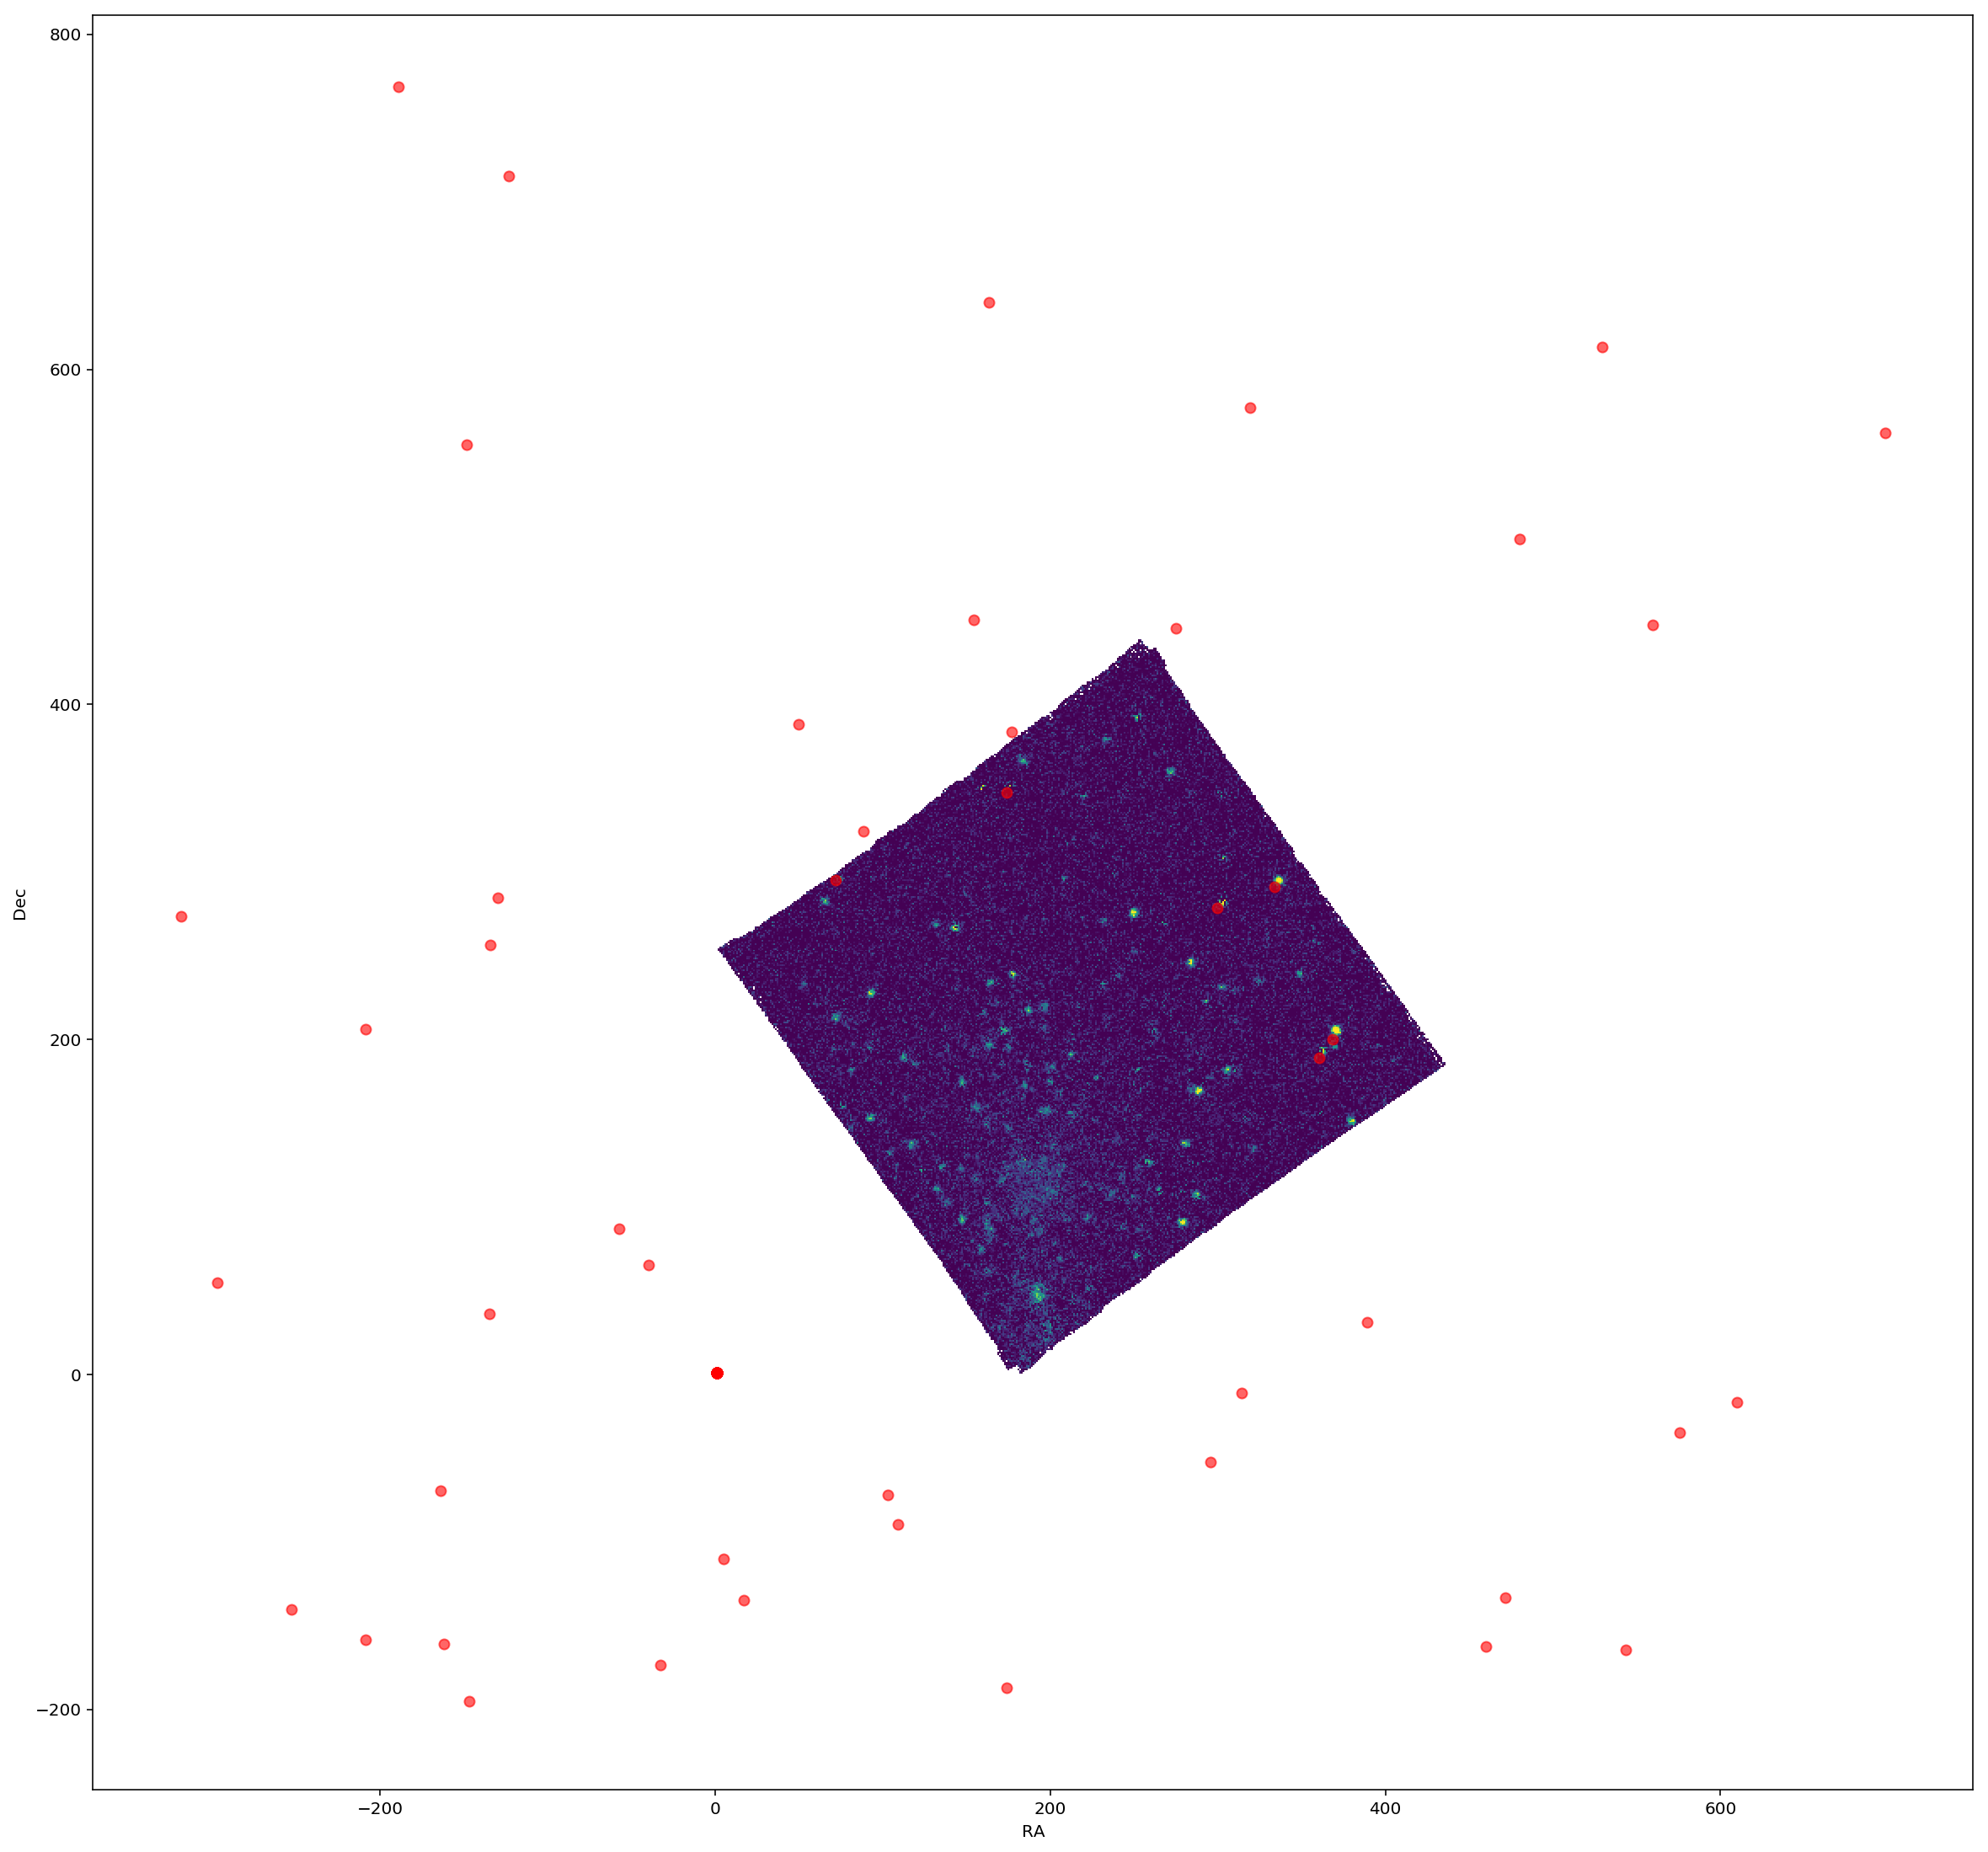

In [62]:
PNe_hdulist = fits.open("PNe1404.fit")
list_1404 = PNe_hdulist[1].data
list_1404 = list_1404[-47:]
RA_1404 =    [list_1404[i][7] for i in np.arange(0,len(list_1404))]
Dec_1404 =   [list_1404[i][8] for i in np.arange(0,len(list_1404))]
m5007_1404 = [list_1404[i][4] for i in np.arange(0,len(list_1404))]

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(list_1404)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(RA_1404[i], u.hourangle), dec=Angle(Dec_1404[i], u.deg), frame="fk5"), wcs_obj)


gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
#plt.xlim(0,500)
#plt.ylim(0,500)
plt.xlabel('RA')
plt.ylabel('Dec')


smallest_sep = []
for r,d in zip(RA_1404, Dec_1404):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
print(indx[np.where(diff<0.001)])
PNe_df.iloc[indx[np.where(diff<0.001)]]

(24, 31)

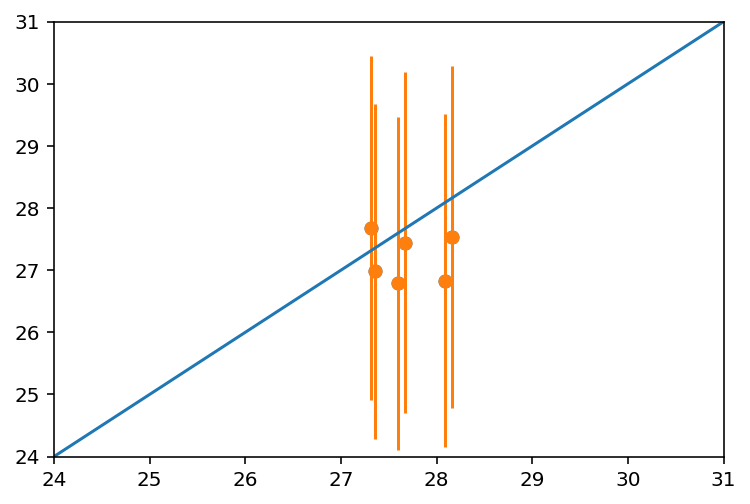

In [63]:
plt.figure()
plt.scatter(PNe_df["m 5007"].iloc[indx[np.where(diff<0.001)]].values, np.array(m5007_1404)[[np.where(diff<0.001)]])
plt.plot(np.arange(24,32), np.arange(24,32))
y_10_per = 10*(np.array(m5007_1404)[np.where(diff<0.001)]/100)
x_err = PNe_df["m 5007 error"].iloc[indx[np.where(diff<0.001)]].values
x_dat = PNe_df["m 5007"].iloc[indx[np.where(diff<0.001)]].values
y_dat = np.array(m5007_1404)[np.where(diff<0.001)]
plt.errorbar(x_dat, y_dat, yerr=y_10_per, xerr=x_err, fmt="o")
plt.xlim(24,31)
plt.ylim(24,31)

Text(0.5, 0, '$m_{5007} $ values MUSE')

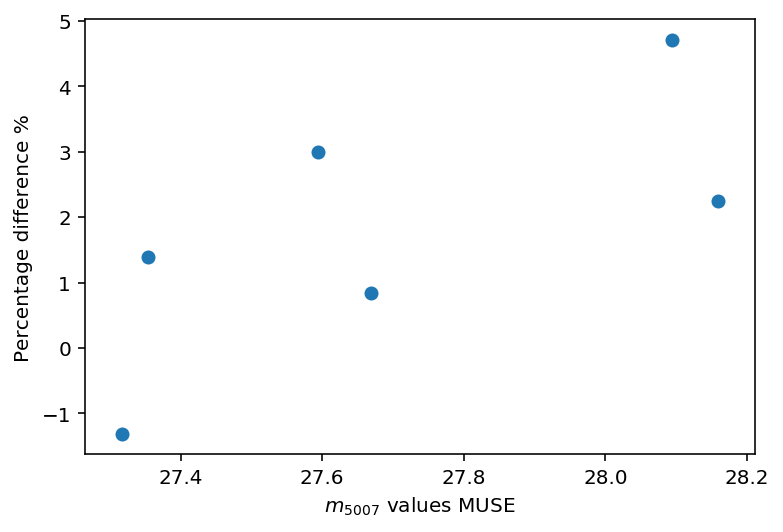

In [70]:
y_d = 100*((x_dat - y_dat)/y_dat)
x_d = 100*((y_dat-x_dat)/x_dat)

plt.scatter(x_dat, y_d)
plt.ylabel("Percentage difference %")
plt.xlabel("$m_{5007} $ values MUSE")

## Completeness testing

In [16]:
x_data_cen, y_data_cen, map_cen, aux = open_data(gal_name)

image, wave = reconstructed_image(gal_name)
image = image.reshape([y_data_cen,x_data_cen])

mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values

# Total PNLF
PNLF, PNLF_corr, Abs_M = completeness(gal_name, mag, PNe_multi_params, Dist_est, image, peak=3., mask=True, c1=0.307 ) # Estimating the completeness for the central pointing
#PNLF_plus, PNLF_corr_plus, Abs_M_plus = completeness(gal_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing
#PNLF_min, PNLF_corr_min, Abs_M_min = completeness(gal_name, mag, PNe_multi_params, D_est_plus, image, 2.75, mask=True ) # Estimating the completeness for the central pointing

# Getting the normalisation
total_norm = np.sum(PNLF_corr)*abs(Abs_M[1]-Abs_M[0])
#total_norm_plus = np.sum(PNLF_corr_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#total_norm_min = np.sum(PNLF_corr_min)*abs(Abs_M_min[1]-Abs_M_min[0])

# Scaling factor
scal = len(mag)/total_norm
#scal_plus = len(mag)/total_norm_plus
#scal_min = len(mag)/total_norm_min

# Constraining to -2.0 in magnitude
idx = np.where(Abs_M <= -2.5)
# Total number of PNe
tot_N_PNe = np.sum(PNLF_corr[idx]*scal)*abs(Abs_M[1]-Abs_M[0])
#tot_N_PNe_plus = np.sum(PNLF_corr_plus[idx]*scal_plus)*abs(Abs_M_plus[1]-Abs_M_plus[0])
#tot_N_PNe_min = np.sum(PNLF_corr_min[idx]*scal_min)*abs(Abs_M_min[1]-Abs_M_min[0])

plt.figure(figsize=(14,10))

binwidth = 0.2
hist = plt.hist(mag, bins=np.arange(min(mag), max(mag) + binwidth, binwidth), edgecolor="black", linewidth=0.8, alpha=0.5, color='blue')

ymax = max(hist[0])

plt.plot(Abs_M, PNLF*scal*binwidth, '-', color='blue', marker="o")
plt.plot(Abs_M, PNLF_corr*scal*binwidth,'-.', color='blue')

plt.xlabel('$M_{5007}$', fontsize=20)
plt.ylabel('N PNe', fontsize=20)
#plt.yticks(np.arange(0,ymax+4, 5))

plt.xlim(-5.0,-2.0); plt.ylim(0,ymax+10);

#plt.axvline(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"].values.min() - 31.63)

#plt.savefig("Plots/"+gal_name+"/"+gal_name+"_PNLF.pdf")

NameError: name 'PNe_df' is not defined

In [67]:
step = Abs_M[1]-Abs_M[0]
print(np.sum(PNLF[:21]*scal)*step)

210.41199183958668


## Alpha

In [ ]:
#original_hdulist = fits.open(gal_name+"_data/"+gal_name+"center.fits")
#original_data = original_hdulist[1].data

# Collapse cube in x and y
#s = np.shape(original_hdulist[1].data)
#collap_cube = np.nansum(original_hdulist[1].data.reshape(s[0],s[1]*s[2]), 1)

#plt.plot(collap_cube)

